# Customer segmentation (clustering)
## Hotel client data

## Initial setup and modules/packages loading

In [1]:
#Market Segment is not that usefull, and it many times is classified incorrectly, and it is correlated with Dist Channel whihc is more import

#Room Nights is more usefull than person nights


In [2]:
#new feature total bookings and percentages for the bookings

#accomodation revenue = lodging - others

#Important: Distribution Channel

#Crib = children

#Possibly get Continent column

#Dont need both name and document number, only document should suffice

#Check for duplicates, NO Duplicates

#Picky clients

#busi s holiday trip

#elevator near -> old people / kids

#Opçao de Target Variable

#Average Leadtime -> bus vs holiday trip

#Kids probably wont make reservations - filter out through age, Afinal podem estar só registados como clientes mas o resto da info ser dos pais

#people with the same id, the numbers of bookings should be the same, OR it should assume the one with the highest number of bookings since that would be its last booking

#30 000 registos sem nada nos bookings dropar ou group
# 
#é naboa dropar caralhos de info

#same Ids

#nº de check ins

# ids with different number of bookings look into its dateof creation para confirmar se somas ou assumes o mais recente

#doc Id podem repetir de paises para paises por isso o mm ID pode ser pessoas diferentes

#Os usuallys podem reprensentar a ultima vez(se da ultima vez pediu KingSize) ou acumular(se em media pede KingSize)

#Ou assumir o ultimo created date

#Separa os paises por continentes e/ou considerar a European Union visto que é mais facil viajar entre eles

#paises como a russia q faz parte de 2 continentes temos de decidir onde a meter, Asia provavelmente. Tambem podemos so assumir European union or else


In [3]:
#transcontinental countries predominant continent - https://en.wikipedia.org/wiki/List_of_transcontinental_countries

#Russia - Asia
#Turkey - Asia
#Kazakhstan - Asia
#Egypt - Africa
#Azerbaijan - Asia
#Georgia - Asia
#Cyprus - Europe
#Armenia - Asia
#Iran - Asia

In [4]:
#Only Cyprus is Transcontinental and in the European Union 


In [5]:
#!pip install joypy
#!pip install category_encoders
#!pip install yellowbrick


In [6]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

In [7]:
from sklearn.impute import KNNImputer

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [10]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

## Data understanding

In [11]:
# Load data 
ds = pd.read_csv('Case1_HotelCustomerSegmentation.csv', sep=";")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

In [12]:
ds_original = ds.copy()

In [13]:
# Display top 5 rows
ds.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,111733.0,NaN,NaN,NaN,55867.0,32254.683151,1.0,27934.0,55867.0,83800.0,111733.0
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0


In [15]:
#Check for duplicates
ds.duplicated().sum()

0

# Outliers

In [16]:
#Confirm the columns with missing values
ds.isnull().sum()[ds.isnull().sum() > 0]

Age          4172
DocIDHash    1001
dtype: int64

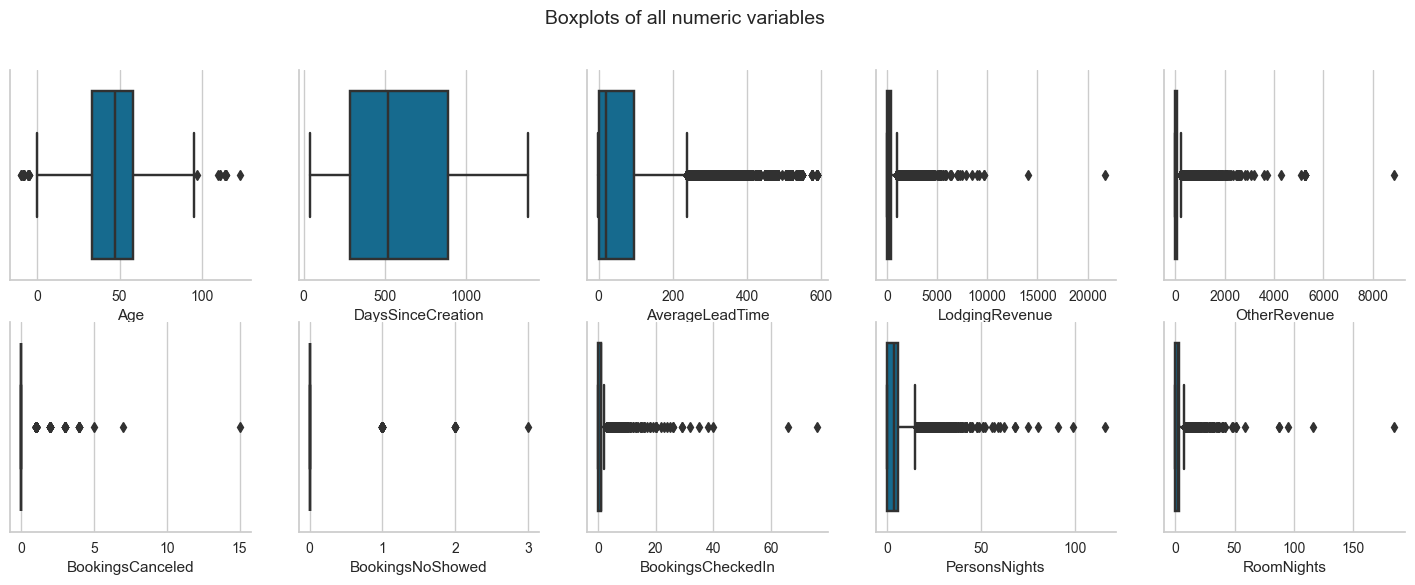

In [17]:
numeric_feat = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights']
#Do box plots for the numeric feat
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(numeric_feat, ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize);

### Since we will do a lot of feature engineering in which we will turn most of these numercial features into classes we wont take out that many outliers

## Manual Removal

In [18]:
#Incoherences
#Changing the negative ages in positive, problably an tipping error
ds['Age'] = ds['Age'].abs()

In [19]:
#Filter for the age, remove the negatives and the older than 100
ds = ds[(ds['Age'].between(0, 100) | ds['Age'].isnull())]

In [20]:
#how many cases have average lead time > 400
ds[ds['AverageLeadTime'] > 400].shape[0]

802

In [21]:
#So that it doesnt affect the KNN too much, we will convert the average lead time values that are over 366 to 366 because we will later create a feature with it
ds['AverageLeadTime'] = ds['AverageLeadTime'].apply(lambda x: 366 if x > 366 else x)

In [22]:
#how many cases of lodging revenue > 10000
ds[ds['LodgingRevenue'] > 10000].shape[0]

2

In [23]:
#Drop them
ds = ds[(ds['LodgingRevenue'] <= 10000)]

In [24]:
#how many cases of other revenue > 4000
ds[ds['OtherRevenue'] > 3500].shape[0]

14

In [25]:
#Drop them
ds = ds[(ds['OtherRevenue'] <= 3500)]

In [26]:
#how many cases of bookings canceled > 10
ds[ds['BookingsCanceled'] > 10].shape[0]

1

In [27]:
#Drop them
ds = ds[(ds['BookingsCanceled'] <= 10)]

In [28]:
#Count the n of bookings no showed
ds['BookingsNoShowed'].value_counts()

BookingsNoShowed
0    111650
1        48
2         8
3         1
Name: count, dtype: int64

In [29]:
#Drop the ones that are over 1
ds = ds[(ds['BookingsNoShowed'] <= 1)]

In [30]:
#Check the bookings checked in with the highest values
ds['BookingsCheckedIn'].value_counts()

BookingsCheckedIn
1     76455
0     33195
2      1633
3       200
4        57
5        33
7        30
6        19
9        13
8        12
10       12
11        6
13        5
15        5
16        4
12        3
20        3
26        2
18        2
24        1
23        1
22        1
29        1
14        1
17        1
38        1
66        1
35        1
Name: count, dtype: int64

In [31]:
#drop the ones that are over 20
ds = ds[(ds['BookingsCheckedIn'] <= 20)]

In [32]:
#Check the person nights with the 15 highest values
ds['PersonsNights'].value_counts().tail(15)

PersonsNights
44    4
48    3
38    3
68    2
31    2
45    2
49    1
29    1
56    1
52    1
91    1
37    1
59    1
57    1
60    1
Name: count, dtype: int64

In [33]:
#Drop the ones that are over 60
ds = ds[(ds['PersonsNights'] <= 60)]

In [34]:
#Check the room nights with the 15 highest values
ds['RoomNights'].value_counts().tail(15)

RoomNights
24    4
31    3
32    3
20    2
48    1
59    1
42    1
39    1
37    1
88    1
40    1
30    1
23    1
29    1
36    1
Name: count, dtype: int64

In [35]:
#How many roomnights values are over 45
ds[ds['RoomNights'] > 45].shape[0]


3

In [36]:
#drop the ones that are over 45
ds = ds[(ds['RoomNights'] <= 45)]

In [37]:
ds.shape[0] / ds_original.shape[0]

0.9995525046315771

# Data Exploration

In [38]:
ds['DocIDHash'].nunique()

103454

In [39]:
#check for nans in DocIDHash
ds['DocIDHash'].isna().sum()   #1001 vai de acordo com o ds.info()

1001

In [40]:
110732-103480

7252

In [41]:
#How many DocIDHash appear more than once
ds['DocIDHash'].value_counts()

DocIDHash
0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855    3030
0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B      28
0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52      23
0x469CF1F9CF8C790FFA5AD3F484F2938CBEFF6435BCFD734F687EC6D1E968F076      15
0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158F8309E6281185C042003      14
                                                                      ... 
0x2BE3FEAFE39DA0AD1CCD18EA3431B904E45A887628B45E3CE9584642EB0A9CE5       1
0x7EC8BADB993449373704A84592ED36BF9CD7152809C94A663A831049FBB74F1F       1
0x5825AA46E4884EF879A26E514C9D0E91AAE46494F128B0AD44D81AD639DD5A26       1
0x68C8B2108F69FF2A322604377D0DE06789F07832D156036729C355779937BEF2       1
0xD539E89183AB389864B7A24B3C1FBC1FE20A40ED02E7CE438BCBA07BB1012304       1
Name: count, Length: 103454, dtype: int64

In [42]:
#How many uniques based on the DocIDHash and Nationality
ds.groupby(['DocIDHash', 'Nationality']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,DocIDHash,Nationality,count
92186,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,PRT,3028
66382,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,PRT,28
17707,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,PRT,23
28809,0x469CF1F9CF8C790FFA5AD3F484F2938CBEFF6435BCFD...,PRT,15
17278,0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158...,CHE,14
...,...,...,...
35052,0x56206149B1ABB9C6E6CB7C009DEBAAF8288F735C3E51...,ESP,1
35051,0x56200F6D85F328EAE670D6F53237CCC3B01F9E1C4A3B...,BRA,1
35049,0x561DBFF040C51B417C723883D87FFCB3A71CE7BDB75D...,USA,1
35048,0x561C3895976596C7CF33D65038873966A4F763D36319...,PRT,1


In [43]:
103711 - 103480

231

## 103711 uniques, VS 103480 initially  -->  Means that 231 people have the same id number but are from different countries

In [44]:
#Group by DocIDHash, NameHash and Nationality
ds.groupby(['NameHash','DocIDHash', 'Nationality']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,NameHash,DocIDHash,Nationality,count
59780,0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A9...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,PRT,18
105640,0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D87...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,PRT,14
39355,0x5D6D35B2A085C783FB5EAA6088C9C97EE3596F2FB552...,0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158...,CHE,13
86270,0xCD38FE774A83198829377D15E818F31ED0A00E932080...,0x8FA8EB6D044E4F2C691C2091FAB27B92FEFE22122F41...,AUT,10
26764,0x3F7AC57386BCF3165796D2B67A548552CA0B7D387E74...,0x6B421376B94F3D1722979458A96DF486DEA0F9290CC0...,DNK,10
...,...,...,...,...
36256,0x55F925AFB99D51EDC3B5B37773594EA3A1569B16391E...,0x06E497827175B17F8B8B2128A3F41287C582FBB1B148...,GBR,1
36255,0x55F8133405B634534239C1663C764CC919EE6AD45146...,0x798570B40958A2E56C6F5CE6CFCF9D1A1470B0FA54D2...,SWE,1
36254,0x55F7457FDC31A1D23548C27E65B448D8D51C4DC11E86...,0xFF914CCD732B1270D6B5AD4B282E92CAF617525FED0A...,DNK,1
36253,0x55F735BB0BA65359EECE9E60D51266D33B30CF9B1ECB...,0x45801C95986E288F2C207FBEAE9DCCE14B6B990BF459...,ESP,1


In [45]:
ds['NameHash'].nunique()

107553

In [46]:
ds['NameHash'].isna().sum()

0

In [47]:
#How many appear more than once
ds['NameHash'].value_counts()

NameHash
0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51EF134B078B9D61A8CC4A    75
0xF1465EC9E2D0027094B7C3D72772A862A635E461FFFC9AA009C2BD78D31BBB63    30
0xD32FF3D74C193EF22762853A9F3DFAE05172A9537CCA78A8D519372EB35BB910    20
0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A960AD7D9A7FB4EC61D02F    18
0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D8787F8C7A413529295FD50    14
                                                                      ..
0xF5EBE240549D19F509FCAC519299217928A58ED84B60B2E051276912DCD8EC22     1
0x5A7843B96A189703C00308EAF44A0554566EDD6AB9DDFDA1A2195FC38FC1CFF8     1
0x4DAFA720DCFC09D1BD67C54935BC78A272BF23DDB8D21CEBEEA2CFCAFC059F14     1
0x839E6BC7EEBFC9B7CFC9CC7FDAEAE58BA7422EA113C7FD9B7B038B6E380913DF     1
0xE52EE501843E3108F20BB8F2EC180D8654DF1424EFA2A6CCC2AAC27CF7326143     1
Name: count, Length: 107553, dtype: int64

## Now one name with 75 reservations is feasible

In [48]:
#The rows where the DocIDHash is 0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855
ds[ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.00,53.0,0,...,0,0,0,0,0,0,0,0,0,0
38,39,PRT,NaN,1385,0xF365E1EC454A18DB722D1DBD8886E027CD4B1234B8A9...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
39,40,PRT,NaN,1385,0x581FBBDFCA174BB597E096E3A9CBED5E1A9FD615844B...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
55,56,PRT,NaN,1385,0xD27550946D0D4D9A2C8ACABC25F3EB2E71340638AB58...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,97,213.52,11.5,0,...,0,0,0,0,0,0,0,0,0,0
59,60,PRT,NaN,1385,0xDB729ABCD594E05BE66D31E3E7A89CF84A107E637368...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,123.00,12.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109483,109484,PRT,NaN,54,0xA011EA37E7B0E7AFCF0B891BC8806A9421A8B6D1291D...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,36,708.00,272.5,0,...,0,0,0,0,0,0,0,0,0,0
109889,109890,PRT,NaN,51,0x931C54BCE9C4AF9C876BDE0E1266BDE69C32E5F7D66D...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,75,616.60,72.0,0,...,0,0,0,0,0,1,0,0,0,0
110525,110526,PRT,NaN,47,0x892C54F8D6C0196FFDE05F31F0C52870F681C39B8C07...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,98,119.00,88.0,0,...,0,0,0,0,0,0,0,0,0,0
110671,110672,PRT,NaN,45,0x64A24B438F81CCBF577AFCEE5A290F1A897D71ADCD06...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,23,59.00,8.0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#When DocIDHash is 0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855 and age is nan
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['Age'].isna())]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.00,53.0,0,...,0,0,0,0,0,0,0,0,0,0
38,39,PRT,NaN,1385,0xF365E1EC454A18DB722D1DBD8886E027CD4B1234B8A9...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
39,40,PRT,NaN,1385,0x581FBBDFCA174BB597E096E3A9CBED5E1A9FD615844B...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.00,0.0,0,...,0,0,0,0,0,0,0,0,0,0
55,56,PRT,NaN,1385,0xD27550946D0D4D9A2C8ACABC25F3EB2E71340638AB58...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,97,213.52,11.5,0,...,0,0,0,0,0,0,0,0,0,0
59,60,PRT,NaN,1385,0xDB729ABCD594E05BE66D31E3E7A89CF84A107E637368...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,123.00,12.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109483,109484,PRT,NaN,54,0xA011EA37E7B0E7AFCF0B891BC8806A9421A8B6D1291D...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,36,708.00,272.5,0,...,0,0,0,0,0,0,0,0,0,0
109889,109890,PRT,NaN,51,0x931C54BCE9C4AF9C876BDE0E1266BDE69C32E5F7D66D...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,75,616.60,72.0,0,...,0,0,0,0,0,1,0,0,0,0
110525,110526,PRT,NaN,47,0x892C54F8D6C0196FFDE05F31F0C52870F681C39B8C07...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,98,119.00,88.0,0,...,0,0,0,0,0,0,0,0,0,0
110671,110672,PRT,NaN,45,0x64A24B438F81CCBF577AFCEE5A290F1A897D71ADCD06...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,23,59.00,8.0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#When DocIDHash is 0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855 and age is not nan
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['Age'].notna())]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
744,745,PRT,40.0,1359,0xDE75217D31BF3A07C97BC70DF817FCBA6CC5AA29C153...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,103,388.0,120.0,0,...,0,0,0,0,0,0,0,0,0,0
842,843,PRT,48.0,1355,0x927BA21A63552D1FC65670C559845E2B3C19BCC55B18...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,17,177.0,77.0,0,...,0,0,0,0,0,0,0,0,0,0
907,908,PRT,33.0,1352,0x3CA9DDAB19D8F50A425B14FAB6BA283701AB9B5A651C...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3,73.0,7.0,0,...,0,0,0,0,0,0,0,0,0,0
1002,1003,PRT,31.0,1348,0x13B95955F49C8E660F3B7639FDAB4BB75A495493A5A2...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,22,172.8,42.0,0,...,0,0,0,0,1,0,0,0,0,0
1003,1004,PRT,30.0,1348,0x155357372FF051877CBE53E7A357935957CB3F22F8D7...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103345,103346,PRT,23.0,103,0x3B383C03E88F6AFE5508D1E75BBDCB6FE13548B1BDA9...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,116.0,16.0,0,...,0,0,0,0,0,1,0,0,0,0
106428,106429,PRT,10.0,78,0x8C93F42F7CE50F07E1B226CDD2111A5413903FA1EC73...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
107858,107859,PRT,6.0,67,0x151FA6F1DCAD61BDCEF01D315AE43293597CE08B0F10...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
108450,108451,PRT,56.0,62,0xD8F7D032DC3955A24CC5394935C8EDC4D06B77812C8A...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,170,314.0,32.0,0,...,0,0,0,0,0,1,0,0,0,0


In [51]:
#When DocIDHash is 0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855 and Nationality is not PRT
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['Nationality'] != 'PRT')]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
30816,30817,PAN,NaN,848,0x3D101FD8EB30B03A16E6FFDD0151B151B6AE790BA784...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,2,208.0,39.0,0,...,0,0,0,0,0,0,0,0,0,0
75055,75056,ESP,NaN,377,0x14A77C11BA7C3B13207E72D4BA395580338D206DCA65...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,69,488.0,49.0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#When DocIDHash is 0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855 and SRCrib is 1
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['SRCrib'] == 1)]

#Only 24 cases we could consider outliers/droping them

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
1860,1861,PRT,NaN,1329,0x92E02A23DE284057198DA77247380E0368BDF0CABE37...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,630.00,51.0,0,...,0,0,0,1,0,0,0,0,0,0
1986,1987,PRT,NaN,1326,0x92E02A23DE284057198DA77247380E0368BDF0CABE37...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,4,210.00,44.8,0,...,0,0,0,1,0,0,0,0,0,0
3247,3248,PRT,NaN,1306,0xF097335EBF60CB9AA3A8A8A786BB6F1934DB6BC2D6A4...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,323.00,54.0,0,...,0,0,0,1,1,0,0,0,0,0
3904,3905,PRT,NaN,1292,0xB36F470F8EEE7B9264BF2668457A7817E31CF149CEC3...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,46,346.00,82.0,0,...,0,0,0,1,0,0,0,0,0,0
8103,8104,PRT,NaN,1221,0xCC19E864BC0F2B41F1B9D39CB3B68C22D5F91BDA7000...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,137,275.04,107.3,0,...,0,0,0,1,1,0,0,0,0,0
9715,9716,PRT,NaN,1197,0xC78440FDD3D2873D2F1963360D2A16D99C82F21A5019...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,51,541.20,115.0,0,...,0,0,0,1,1,0,0,0,0,0
10062,10063,PRT,NaN,1191,0xC9BCFB8F2D58CA1126F078B061967AC06803A3B3E69C...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,152,522.00,204.0,0,...,0,0,0,1,1,0,0,0,0,0
10115,10116,PRT,NaN,1190,0xC4204DE60C58D4F5DB7D523BF1E10FAB83840816B6B7...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,69,375.00,259.3,0,...,0,0,0,1,1,0,0,0,0,0
11168,11169,PRT,NaN,1174,0xD9ED73AB562CA5330592DF2C141788F91E36A8FC0AA2...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,53.00,14.0,0,...,0,0,0,1,1,0,0,0,0,0
20274,20275,PRT,NaN,1024,0x15BD54FBB5CEACAB9B6504FC6D30C051AA6EA9EE1F5F...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,1,100.00,18.0,0,...,0,0,0,1,1,0,0,0,0,0


In [53]:
#The previous cell but grouped by namehash to check if they were always the same guys
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['SRCrib'] == 1)].groupby('NameHash').size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

#They werent


,NameHash,count
20,0xE0D87F9493974A34453530FC227FFFE8AC7494BD2010...,2
8,0x92E02A23DE284057198DA77247380E0368BDF0CABE37...,2
0,0x002269EBD682C29B2570745C10E980CEC8F7A10C0411...,1
12,0xAD091B4A615F01C9D5C11AC55AAF5DC4F540203A59D9...,1
19,0xD9ED73AB562CA5330592DF2C141788F91E36A8FC0AA2...,1
18,0xD94D82347BA323D572E52A96F5D50223B306C5F130E1...,1
17,0xCC19E864BC0F2B41F1B9D39CB3B68C22D5F91BDA7000...,1
16,0xC9BCFB8F2D58CA1126F078B061967AC06803A3B3E69C...,1
15,0xC78440FDD3D2873D2F1963360D2A16D99C82F21A5019...,1
14,0xC4204DE60C58D4F5DB7D523BF1E10FAB83840816B6B7...,1


In [54]:
#Grouping by market segment and distribution channel~
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['SRCrib'] == 0)][['MarketSegment', 'DistributionChannel']].groupby(['MarketSegment', 'DistributionChannel']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)


,MarketSegment,DistributionChannel,count
17,Other,Travel Agent/Operator,1134
13,Groups,Travel Agent/Operator,595
9,Direct,Direct,500
20,Travel Agent/Operator,Travel Agent/Operator,366
5,Corporate,Corporate,226
3,Complementary,Direct,80
0,Aviation,Corporate,20
7,Corporate,Travel Agent/Operator,19
11,Groups,Corporate,17
16,Other,GDS Systems,16


In [55]:
#Group only by market segment
ds[(ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855') & (ds['SRCrib'] == 0)][['MarketSegment']].groupby(['MarketSegment']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,MarketSegment,count
5,Other,1153
4,Groups,617
3,Direct,506
6,Travel Agent/Operator,374
2,Corporate,248
1,Complementary,87
0,Aviation,21


## We'll merge the same people by their last entrance

In [56]:
#Check how many docIds duplicate
ds['DocIDHash'].value_counts()

DocIDHash
0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855    3030
0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B      28
0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52      23
0x469CF1F9CF8C790FFA5AD3F484F2938CBEFF6435BCFD734F687EC6D1E968F076      15
0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158F8309E6281185C042003      14
                                                                      ... 
0x2BE3FEAFE39DA0AD1CCD18EA3431B904E45A887628B45E3CE9584642EB0A9CE5       1
0x7EC8BADB993449373704A84592ED36BF9CD7152809C94A663A831049FBB74F1F       1
0x5825AA46E4884EF879A26E514C9D0E91AAE46494F128B0AD44D81AD639DD5A26       1
0x68C8B2108F69FF2A322604377D0DE06789F07832D156036729C355779937BEF2       1
0xD539E89183AB389864B7A24B3C1FBC1FE20A40ED02E7CE438BCBA07BB1012304       1
Name: count, Length: 103454, dtype: int64

In [57]:
# out of the 3030 duplicates, check the no show bookings
ds[ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']['BookingsNoShowed'].value_counts()

BookingsNoShowed
0    3025
1       5
Name: count, dtype: int64

In [58]:
# out of the 3030 duplicates, check the no show bookings
ds[ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']['BookingsCanceled'].value_counts()

BookingsCanceled
0    3009
1      20
2       1
Name: count, dtype: int64

In [59]:
#Check the distribution channel and market segment of this docId
ds[ds['DocIDHash'] == '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855'][['DistributionChannel', 'MarketSegment']].groupby(['DistributionChannel', 'MarketSegment']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,DistributionChannel,MarketSegment,count
19,Travel Agent/Operator,Other,1141
18,Travel Agent/Operator,Groups,596
9,Direct,Direct,510
20,Travel Agent/Operator,Travel Agent/Operator,368
2,Corporate,Corporate,227
7,Direct,Complementary,81
0,Corporate,Aviation,20
16,Travel Agent/Operator,Corporate,19
4,Corporate,Groups,18
13,GDS Systems,Other,16


## Since the values are too inconsistent and following the professor's advice we will drop them

In [60]:
ds.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
#Drop this Duplicate
ds = ds[ds['DocIDHash'] != '0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855']

In [62]:
#check for duplicates
ds.duplicated().sum()

0

In [63]:
#Check for duplicates in the same people
ds.groupby(['NameHash','DocIDHash', 'Nationality']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,NameHash,DocIDHash,Nationality,count
58246,0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A9...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,PRT,18
102871,0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D87...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,PRT,14
38357,0x5D6D35B2A085C783FB5EAA6088C9C97EE3596F2FB552...,0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158...,CHE,13
84036,0xCD38FE774A83198829377D15E818F31ED0A00E932080...,0x8FA8EB6D044E4F2C691C2091FAB27B92FEFE22122F41...,AUT,10
26104,0x3F7AC57386BCF3165796D2B67A548552CA0B7D387E74...,0x6B421376B94F3D1722979458A96DF486DEA0F9290CC0...,DNK,10
...,...,...,...,...
35283,0x55CCAE66FFB5ABFEBFB1C899D67092C3331DF75A072D...,0xD3B1BF7E6DB0F8CA873AE21574EC95E2C7BDE0B2BE69...,DEU,1
35282,0x55CC9A5802A22AFA0397B6B7D5035EA08C9F6CE23990...,0x0E52EE07AE3AD9EDD88163F9D0456FC8C66F757874B8...,PRT,1
35281,0x55CC98766BA0EDAEAD9A4B65A5AE3646ED820F460D14...,0x9FA38614F0A0DEC3D469C8E58DFDA917665FCD3ECFD1...,ITA,1
35280,0x55CC1DFE3EF1EE056EE58EAC049CE54D823904AF1DF9...,0xB655D537EE64DC532B03D8CE75450CD0FAB5FABCEA99...,AUT,1


In [64]:
#Out of those that appear more than once (duplicates) keep only the one with the highest days since creation
ds = ds.sort_values('DaysSinceCreation', ascending=False).drop_duplicates(['DocIDHash', 'NameHash', 'Nationality'])

In [65]:
#Confirm
ds.groupby(['NameHash','DocIDHash', 'Nationality']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

,NameHash,DocIDHash,Nationality,count
0,0x000093906C9FA7A54C937EF1848D4AA5F79F104D8365...,0xFBB48E8A898A0973E8FC147D2AC89307B16EE4D6B618...,BRA,1
69844,0xAA7B8573DAB5AC12E610B24C3B223D6656804FAAD503...,0x7F8D32ABDB684C6479FDC14C524D56C8C1CFAA5901B7...,USA,1
69854,0xAA7EBDDA47DC52D6000C8F9884257FE4609848F17818...,0xEBD353AC5701120C0C4068915AE6FFDBB6004D277CCB...,FRA,1
69853,0xAA7EB5C31CDEFB99987D7B65E897B0302B168742A564...,0x47821A3B17E031C5EF1245E3E3667A2746DDD32A7B08...,ESP,1
69852,0xAA7E60366B9816F522642FCE747BD5BBDB5B8D455BC4...,0x2AB8EF024EC81934248795D775CED3034C86DFABE1A6...,BEL,1
...,...,...,...,...
34920,0x54E824BA2402D85423D947E89A026C249AF67CBB4201...,0x98C0B00FE94B02E8E439BED27736202774935A7D7882...,PRT,1
34919,0x54E79F7BB88CAFB2DE5B287FD047CF4531BCA80DE9FB...,0x89432E3943654478300AA62C6D40511B50EFDC7D9A6F...,FRA,1
34918,0x54E6AA4655BEE32915471DFB9D38B1B7CCEBC04223B0...,0xE7BB9A28F5C2812492EFB31A74E43DCC5A33BA964F1F...,SWE,1
34917,0x54E60AA43AA43D363C0CE222383D764D6D7CE664B9FA...,0x7AA27D29AAA694A94887BA182533D0AB1F4C434FA881...,NOR,1


In [66]:
ds['MarketSegment'].unique()

array(['Complementary', 'Direct', 'Travel Agent/Operator', 'Other',
       'Corporate', 'Groups', 'Aviation'], dtype=object)

In [67]:
ds['DistributionChannel'].unique()

array(['Direct', 'Travel Agent/Operator', 'Corporate', 'GDS Systems'],
      dtype=object)

In [68]:
# Check counts of categorical variables,                                             ESTA N PERCEBI BEM
categorical_features = ['MarketSegment', 'DistributionChannel'] # + ID and Name
ds[categorical_features].apply(pd.Series.value_counts)

,MarketSegment,DistributionChannel
Aviation,207.0,NaN
Complementary,509.0,NaN
Corporate,2260.0,2388.0
Direct,15003.0,15380.0
GDS Systems,NaN,605.0
Groups,10742.0,NaN
Other,61066.0,NaN
Travel Agent/Operator,15770.0,87184.0


In [69]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105557 entries, 58 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    105557 non-null  int64  
 1   Nationality           105557 non-null  object 
 2   Age                   104470 non-null  float64
 3   DaysSinceCreation     105557 non-null  int64  
 4   NameHash              105557 non-null  object 
 5   DocIDHash             104771 non-null  object 
 6   AverageLeadTime       105557 non-null  int64  
 7   LodgingRevenue        105557 non-null  float64
 8   OtherRevenue          105557 non-null  float64
 9   BookingsCanceled      105557 non-null  int64  
 10  BookingsNoShowed      105557 non-null  int64  
 11  BookingsCheckedIn     105557 non-null  int64  
 12  PersonsNights         105557 non-null  int64  
 13  RoomNights            105557 non-null  int64  
 14  DistributionChannel   105557 non-null  object 
 15  Mark

In [70]:
#Table where the MarketSegment is the index and the DistributionChannel is the columns and the values are the counts
pd.crosstab(ds['MarketSegment'], ds['DistributionChannel'])


DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
MarketSegment,,,,
Aviation,203,0,0,4
Complementary,12,389,0,108
Corporate,1580,40,1,639
Direct,11,14641,5,346
Groups,457,162,5,10118
Other,33,122,589,60322
Travel Agent/Operator,92,26,5,15647


In [71]:
ds.shape[0] / ds_original.shape[0]

0.9447253720923988

In [72]:
# Check missing values
print(ds.isnull().sum())

ID                         0
Nationality                0
Age                     1087
DaysSinceCreation          0
NameHash                   0
DocIDHash                786
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


In [73]:
#Confirm the columns with missing values
ds.isnull().sum()[ds.isnull().sum() > 0]

Age          1087
DocIDHash     786
dtype: int64

In [74]:
1087 / ds.shape[0] #We could also drop these, but we will replace them with knn

0.010297753820210882

In [75]:
786 / ds.shape[0]

0.007446213893915136

### Since these nans represent less than 1 % we can drop them

In [76]:
#Drop the rows where DocIDHash is missing
ds = ds.dropna(subset=['DocIDHash'])
ds.shape[0] / ds_original.shape[0]

0.9376907449007903

In [77]:
numeric_features = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed', 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom']
ds[numeric_features].describe()

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,104470.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,...,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.000000,104771.00000,104771.000000,104771.000000
mean,45.588016,588.525823,61.201764,286.847343,64.671298,0.001193,0.000258,0.724704,4.389707,2.214258,...,0.000725,0.003255,0.001699,0.016512,0.367029,0.159958,0.000334,0.00357,0.000210,0.089758
std,17.295354,372.453667,82.154573,369.784880,107.249986,0.044002,0.016051,0.558983,4.594562,2.099260,...,0.026923,0.056957,0.041183,0.127435,0.481997,0.366569,0.018274,0.05964,0.014489,0.285836
min,0.000000,36.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,33.000000,283.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,47.000000,515.000000,23.000000,214.000000,32.000000,0.000000,0.000000,1.000000,4.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,58.000000,880.000000,97.000000,399.500000,86.000000,0.000000,0.000000,1.000000,6.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,97.000000,1385.000000,366.000000,9682.400000,3190.400000,4.000000,1.000000,18.000000,60.000000,42.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [78]:
ds.head()

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
33,34,PRT,44.0,1385,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,78,180.6,100.5,0,...,0,0,0,1,0,0,0,0,0,0
35,36,PRT,64.0,1385,0x2892853ACDE4F91C8DB84FF2FB21F65B83180956A75C...,0xA46A1032FC70B0836182BC3166E4CFAB334F9CD82120...,0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
36,37,DEU,31.0,1385,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,13,210.0,73.0,0,...,0,0,0,0,0,0,0,0,0,0
37,38,DEU,29.0,1385,0x24EB9484B2D7BAD4B3FF132EE367EA244FBA29AC10AF...,0x9E84999F5FB9461674947406469702FF63129F2D0132...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
40,41,ITA,53.0,1385,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,87,563.1,90.0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
#Scale the 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue'
scaler = preprocessing.StandardScaler()
ds[['DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue']] = scaler.fit_transform(ds[['DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue']])

In [80]:
#Use the KNN Imputer to fill the missing values in Age according to the numeric feature
imputer = KNNImputer(n_neighbors=5)
ds['Age'] = imputer.fit_transform(ds[['Age']])
ds['Age'] = ds['Age'].astype(int)

#Check for missing values
ds.isnull().sum()

ID                      0
Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
SRHighFloor             0
SRLowFloor              0
SRAccessibleRoom        0
SRMediumFloor           0
SRBathtub               0
SRShower                0
SRCrib                  0
SRKingSizeBed           0
SRTwinBed               0
SRNearElevator          0
SRAwayFromElevator      0
SRNoAlcoholInMiniBar    0
SRQuietRoom             0
dtype: int64

In [81]:
ds.head()

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
33,34,PRT,44,2.138462,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,0.204472,-0.287323,0.334069,0,...,0,0,0,1,0,0,0,0,0,0
35,36,PRT,64,2.138462,0x2892853ACDE4F91C8DB84FF2FB21F65B83180956A75C...,0xA46A1032FC70B0836182BC3166E4CFAB334F9CD82120...,-0.744962,-0.775718,-0.602999,0,...,0,0,0,1,0,0,0,0,0,0
36,37,DEU,31,2.138462,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,-0.586723,-0.207817,0.077657,0,...,0,0,0,0,0,0,0,0,0,0
37,38,DEU,29,2.138462,0x24EB9484B2D7BAD4B3FF132EE367EA244FBA29AC10AF...,0x9E84999F5FB9461674947406469702FF63129F2D0132...,-0.744962,-0.775718,-0.602999,0,...,0,0,0,0,0,0,0,0,0,0
40,41,ITA,53,2.138462,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,0.314022,0.747067,0.236166,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
#Now return the 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue'values to the original scale
ds[['DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue']] = scaler.inverse_transform(ds[['DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue']])
ds.head()

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
33,34,PRT,44,1385.0,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,78.0,180.6,100.5,0,...,0,0,0,1,0,0,0,0,0,0
35,36,PRT,64,1385.0,0x2892853ACDE4F91C8DB84FF2FB21F65B83180956A75C...,0xA46A1032FC70B0836182BC3166E4CFAB334F9CD82120...,0.0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
36,37,DEU,31,1385.0,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,13.0,210.0,73.0,0,...,0,0,0,0,0,0,0,0,0,0
37,38,DEU,29,1385.0,0x24EB9484B2D7BAD4B3FF132EE367EA244FBA29AC10AF...,0x9E84999F5FB9461674947406469702FF63129F2D0132...,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
40,41,ITA,53,1385.0,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,87.0,563.1,90.0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
#Fixing the AverageLeadTime into the original values
ds['AverageLeadTime'] = ds['AverageLeadTime'].apply(lambda x: round(x))
ds.head()


,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
33,34,PRT,44,1385.0,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,78,180.6,100.5,0,...,0,0,0,1,0,0,0,0,0,0
35,36,PRT,64,1385.0,0x2892853ACDE4F91C8DB84FF2FB21F65B83180956A75C...,0xA46A1032FC70B0836182BC3166E4CFAB334F9CD82120...,0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
36,37,DEU,31,1385.0,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,13,210.0,73.0,0,...,0,0,0,0,0,0,0,0,0,0
37,38,DEU,29,1385.0,0x24EB9484B2D7BAD4B3FF132EE367EA244FBA29AC10AF...,0x9E84999F5FB9461674947406469702FF63129F2D0132...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
40,41,ITA,53,1385.0,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,87,563.1,90.0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
ds['Age'].unique()

array([44, 64, 31, 29, 53, 19, 54, 49, 26, 27, 37, 33, 39, 41, 40, 66, 60,
       51, 14, 52, 62, 32,  4, 18, 42, 72, 61, 55, 50, 28, 59, 57, 43, 58,
       69, 73, 25, 68, 48, 65, 45, 67, 63, 46, 10,  5,  8,  9, 38, 11, 21,
       47,  6, 34, 35, 71,  7, 36, 83, 30, 56, 70, 15, 74, 12, 75,  2, 76,
       16, 84, 79, 77, 22, 78, 20, 23, 13, 24, 80, 81, 17, 82, 85, 86, 88,
       90, 92, 87, 89,  0,  3, 93,  1, 97, 91, 95])

In [85]:
#Check for nans
ds.isnull().sum()

ID                      0
Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
SRHighFloor             0
SRLowFloor              0
SRAccessibleRoom        0
SRMediumFloor           0
SRBathtub               0
SRShower                0
SRCrib                  0
SRKingSizeBed           0
SRTwinBed               0
SRNearElevator          0
SRAwayFromElevator      0
SRNoAlcoholInMiniBar    0
SRQuietRoom             0
dtype: int64

In [86]:
#https://www.touristsecrets.com/travel-guide/hotels/what-is-the-minimum-age-for-making-a-hotel-reservation/
#Says you can only make reservations if you are at least 18 years old

#https://hotelchantelle.com/can-you-book-a-hotel-at-16/
#With parental consent you can make reservations at 16 years old

In [87]:
ds.shape

(104771, 29)

In [88]:
#Whats the oldest and youngest age
ds['Age'].min(), ds['Age'].max()

(0, 97)

In [89]:
#https://www.mentalfloss.com/article/609811/age-ranges-millennials-and-generation-z

#The Silent Generation   79-96 years old                                       # 1. 16-27

#Boomers   60-78 years old                                                     # 2. 28-43

#Gen X   44-59 years old                                                       # 3. 44-59

#Millennials   28-43 years old                                                 # 4. >=60

#Gen Z   12-27 years old --> change to 16-27

#babies 0-4 years old

#kids 5-15 years old

# Feature Engineering

In [90]:
#Since we cant target the babies and kids, we will drop them
#Drop everyone under 16
ds = ds[ds['Age'] >= 16]

In [91]:
#Turn the age into the previous categories
ds['AgeGroup'] = pd.cut(ds['Age'], bins=[15, 27, 43, 59, 125], labels=['16-27', '28-43', '44-59', '>=60'])

In [92]:
ds['AgeGroup'].value_counts()

AgeGroup
44-59    36358
28-43    30138
>=60     22619
16-27    10025
Name: count, dtype: int64

In [93]:
ds['AgeGroup'].isna().sum()

0

## Nice

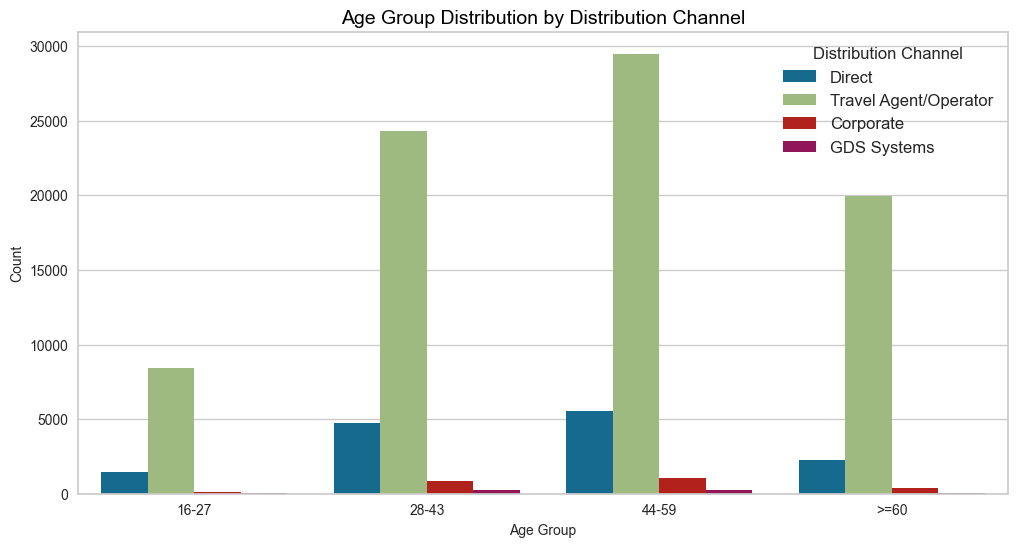

In [94]:
#Distribution plot of the agegroups by distribution channel
plt.figure(figsize=(12, 6))
sns.countplot(data=ds, x='AgeGroup', hue='DistributionChannel')
plt.title('Age Group Distribution by Distribution Channel', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Age Group', fontsize=subPlots_label_fontSize)
plt.ylabel('Count', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.legend(fontsize=plots_Legend_fontSize, title='Distribution Channel')
plt.show()


In [95]:
table2 = pd.crosstab(index=ds['Age'], columns=ds['DistributionChannel'])
table2

DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
Age,,,,
16,2,97,1,433
17,4,94,0,501
18,2,87,0,435
19,5,107,0,468
20,2,97,0,486
...,...,...,...,...
91,0,0,0,2
92,0,0,0,2
93,0,1,0,3


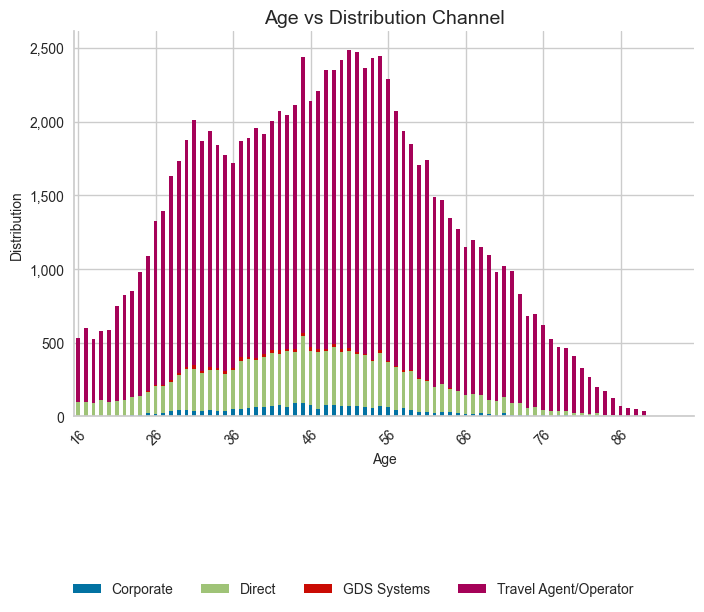

In [96]:
age_ticks = np.arange(0, len(table2.index), 10)

fig, ax = plt.subplots(figsize=(8, 5))
table2.plot(kind="bar", ax=ax, stacked=True)

fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.set_xticks(age_ticks)  
ax.set_xticklabels(table2.index[age_ticks], rotation=45)  
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Age vs Distribution Channel", fontsize=plots_Title_fontSize)
plt.xlabel("Age")
plt.ylabel("Distribution")
plt.rc('axes', labelsize=subPlots_label_fontSize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center', 
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)

plt.show()

In [97]:
table3 = pd.crosstab(index=ds['Nationality'], columns=ds['DistributionChannel'])
table3

DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
Nationality,,,,
ABW,0,0,0,3
AFG,0,0,0,3
AGO,5,121,0,70
AIA,0,0,0,1
ALB,2,4,0,13
...,...,...,...,...
WLF,0,0,0,2
WSM,0,0,0,1
YEM,0,1,0,1


## Feature Engineering

In [98]:
ds['Nationality'].value_counts().head(10)

Nationality
FRA    15344
DEU    14067
GBR    10726
PRT     8932
ESP     5498
USA     4911
ITA     3924
BEL     3783
NLD     3521
BRA     3492
Name: count, dtype: int64

In [99]:
#Create a new column with the continent of the country, however consider the European Union as a continent and the transcontinental countries as the predominant continent
ds['Geo_Area'] = ds['Nationality'] #create the column with the same values
ds['Geo_Area'] = ds['Geo_Area'].replace(['PRT'], 'Portugal')
ds['Geo_Area'] = ds['Geo_Area'].replace(['RUS', 'TUR', 'KAZ', 'AZE', 'GEO', 'ARM', 'IRN'], 'Asia') #replace the values
ds['Geo_Area'] = ds['Geo_Area'].replace(['EGY'], 'Africa') #replace the values
ds['Geo_Area'] = ds['Geo_Area'].replace(['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'], 'European Union')

In [100]:
ds['Geo_Area'].value_counts()

Geo_Area
European Union    57595
GBR               10726
Portugal           8932
USA                4911
BRA                3492
                  ...  
SWZ                   1
SOM                   1
FLK                   1
BHS                   1
BDI                   1
Name: count, Length: 160, dtype: int64

In [101]:
#What are the top 10 countries
ds['Geo_Area'].value_counts().head(15)

Geo_Area
European Union    57595
GBR               10726
Portugal           8932
USA                4911
BRA                3492
CHE                2460
CAN                1990
Asia               1094
ISR                1060
CHN                1031
AUS                 980
NOR                 955
JPN                 311
IND                 239
MEX                 232
Name: count, dtype: int64

## Since there are so many English people we might want to leave as its own category

In [102]:
ds['Geo_Area'] = ds['Geo_Area'].replace(['GBR'], 'European Union')

In [103]:
#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of the Asian countries with Asia
ds['Geo_Area'] = ds['Geo_Area'].replace(['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'BRN', 'KHM', 'CHN', 'GEO', 'HKG', 'IND', 'IDN', 'IRN', 'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO', 'LBN', 'MAC', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'PRK', 'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU', 'SGP', 'KOR', 'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TUR', 'TKM', 'ARE', 'UZB', 'VNM', 'YEM','CCK', 'CXR', 'TMP', 'IOT'], 'Asia') #CCK, CXR,

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of the African countries with Africa
ds['Geo_Area'] = ds['Geo_Area'].replace(['DZA', 'AGO', 'SHN', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD', 'COM', 'COG', 'DJI', 'EGY', 'GNQ', 'ERI', 'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MYT', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'STP', 'REU', 'RWA', 'SHN', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'SWZ', 'TZA', 'TGO', 'TUN', 'UGA', 'COD', 'ZMB', 'ZWE', 'REU', 'SHN'], 'Africa') #REU, SHN,

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of North American countries with North America
ds['Geo_Area'] = ds['Geo_Area'].replace(['ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'CAN', 'CYM', 'CRI', 'CUB', 'CUW', 'DMA', 'DOM', 'SLV', 'GRL', 'GRD', 'GLP', 'GTM', 'HTI', 'HND', 'JAM', 'MTQ', 'MEX', 'MSR', 'ANT', 'KNA', 'NIC', 'PAN', 'PRI', 'BES', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'TTO', 'TCA', 'VIR', 'USA', 'VGB', 'MTQ', 'MSR', 'SPM', 'AIA'], 'North America') #MTQ, MSR, SPM

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of South American countries with South America
ds['Geo_Area'] = ds['Geo_Area'].replace(['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'FLK', 'GUF', 'GUY', 'PRY', 'PER', 'SGS', 'SUR', 'URY', 'VEN', 'FLK'], 'South America')

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of Oceanian countries with Oceania
ds['Geo_Area'] = ds['Geo_Area'].replace(['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 'MHL', 'FSM', 'NRU', 'NCL', 'NZL', 'NIU', 'NFK', 'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TKL', 'TON', 'TUV', 'UMI', 'VUT', 'WLF', 'ASM', 'NIU', 'PCN', 'TKL', 'WLF'], 'Oceania') #ASM, NIU, PCN, TKL, WLF

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of european countries that are not on the European Union with Europe
ds['Geo_Area'] = ds['Geo_Area'].replace(['ALB', 'AND', 'BLR', 'BIH', 'HRV', 'ISL', 'LIE', 'MDA', 'MCO', 'MNE', 'NOR', 'SMR', 'SRB', 'CHE', 'UKR', 'GBR', 'ALA', 'GGY', 'JEY', 'SJM', 'VAT', 'MKD', 'GIB', 'FRO'], 'Europe') #ALA, GGY, JEY, SJM, VAT, MKD, GIB, FRO

#On the continent collumn replace ISO 3166-1 (Alpha 3) codes of the remaining countries with Other
ds['Geo_Area'] = ds['Geo_Area'].replace(['ATA', 'BVT', 'HMD', 'ATF'], 'Antartica') #ATA, BVT, HMD

In [104]:
ds['Geo_Area'].value_counts()

Geo_Area
European Union    68321
Portugal           8932
North America      7264
Asia               4517
South America      4081
Europe             3940
Oceania            1130
Africa              942
Antartica            13
Name: count, dtype: int64

In [105]:
#Group Oceania, Africa and Antartica into Other
ds['Geo_Area'] = ds['Geo_Area'].replace(['Oceania', 'Africa', 'Antartica'], 'Other')

In [106]:
#Check the number of unique values for the categorical variables
ds[categorical_features].nunique()

MarketSegment          7
DistributionChannel    4
dtype: int64

Summary statistics shows:
- Age and DocIDHash present missing values. Other columns present no missing values (in the sense of having no empty columns).
- **MarketSegment** has 7 categories. **DistributionChannel** has 4 categories.

In [107]:
#Binary Features
binary_features = ['SRHighFloor','SRLowFloor','SRAccessibleRoom','SRMediumFloor','SRBathtub','SRShower','SRCrib','SRKingSizeBed','SRTwinBed','SRNearElevator','SRAwayFromElevator','SRNoAlcoholInMiniBar','SRQuietRoom'] #'SRNonSmokingRoom','SRAdjoiningRooms','SRHoneymoon','Segment']

In [108]:
ds[binary_features].nunique()

SRHighFloor             2
SRLowFloor              2
SRAccessibleRoom        2
SRMediumFloor           2
SRBathtub               2
SRShower                2
SRCrib                  2
SRKingSizeBed           2
SRTwinBed               2
SRNearElevator          2
SRAwayFromElevator      2
SRNoAlcoholInMiniBar    2
SRQuietRoom             2
dtype: int64

In [109]:

print(ds['SRHighFloor'].unique())             
print(ds['SRLowFloor'].unique())              
print(ds['SRAccessibleRoom'].unique())        
print(ds['SRMediumFloor'].unique())           
print(ds['SRBathtub'].unique())               
print(ds['SRShower'].unique())                
print(ds['SRCrib'].unique())                  
print(ds['SRKingSizeBed'].unique())           
print(ds['SRTwinBed'].unique())               
print(ds['SRNearElevator'].unique())          
print(ds['SRAwayFromElevator'].unique())      
print(ds['SRNoAlcoholInMiniBar'].unique())    
print(ds['SRQuietRoom'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


## All binary features are binary

## Feature Engineering

In [110]:
#Create a new variable that sums all the SRHighFloor, SRLowFloor, SRAccessibleRoom, SRMediumFloor, SRBathtub, SRShower, SRKingSizeBed, SRTwinBed, SRNearElevator, SRAwayFromElevator, SRNoAlcoholInMiniBar, SRQuietRoom
ds['TotalUsuallys'] = ds['SRHighFloor'] + ds['SRLowFloor'] + ds['SRAccessibleRoom'] + ds['SRMediumFloor'] + ds['SRBathtub'] + ds['SRShower'] + ds['SRCrib'] + ds['SRKingSizeBed'] + ds['SRTwinBed'] + ds['SRNearElevator'] + ds['SRAwayFromElevator'] + ds['SRNoAlcoholInMiniBar'] + ds['SRQuietRoom']

ds['TotalUsuallys'].min(), ds['TotalUsuallys'].max()

(0, 4)

In [111]:
ds['TotalUsuallys'].value_counts()

TotalUsuallys
1    45936
0    42801
2     9476
3      862
4       65
Name: count, dtype: int64

In [112]:
ds['TotalUsuallys'] = ds['TotalUsuallys'].replace({2: '2/3/4', 3: '2/3/4', 4: '2/3/4'})

In [113]:
ds['TotalUsuallys'].value_counts()

TotalUsuallys
1        45936
0        42801
2/3/4    10403
Name: count, dtype: int64

In [114]:
#Incoherence
#Show how many ids have 0 bookings in the BookingsCanceled, BookingsNoShowed, and BookingsCheckedin
ds[(ds['BookingsCanceled'] == 0) & (ds['BookingsNoShowed'] == 0) & (ds['BookingsCheckedIn'] == 0)].shape[0]

26522

In [115]:
#Drop them
ds = ds[~((ds['BookingsCanceled'] == 0) & (ds['BookingsNoShowed'] == 0) & (ds['BookingsCheckedIn'] == 0))]

# Aqui retirei as preferencias dos clientes porque já temos a nova variavel 'TotalUsuallys' - SR

In [116]:
#Removing the clients preferences
ds.drop(['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed', 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom'], axis=1, inplace=True)

## Feature Engineering

In [117]:
ds['LodgingRevenue'].head()

33    180.6
36    210.0
40    563.1
42    455.7
44    251.1
Name: LodgingRevenue, dtype: float64

In [118]:
ds['OtherRevenue'].head()

33    100.5
36     73.0
40     90.0
42     86.5
44     40.5
Name: OtherRevenue, dtype: float64

In [119]:
#Create a new column with the accomodation revenue
ds['TotalRevenue'] = ds['LodgingRevenue'] + ds['OtherRevenue']

# Feature Engineering

In [120]:
#What is the total of noshowed bookings
ds['BookingsNoShowed'].sum()

27

In [121]:
#What is the total revenue of the no showed bookings
ds[ds['BookingsNoShowed'] > 0]['TotalRevenue'].sum()

21998.47

In [122]:
#This means that even if they dont show they pay

In [123]:
ds['RoomNights'].value_counts()

RoomNights
3     19708
2     16117
4     13408
1     11456
5      5941
7      2439
6      2298
8       478
9       250
10      186
11       91
12       60
14       44
13       31
15       31
19       13
16       11
21       10
17       10
18        8
22        5
28        4
24        4
26        3
31        2
20        2
32        2
29        1
23        1
30        1
40        1
0         1
42        1
Name: count, dtype: int64

In [124]:
#Create a new variable called average_spent which is the total revenue divided by the RoomNights
ds['AverageSpentNight'] = ds['TotalRevenue'] / (ds['RoomNights'])

In [125]:
ds['AverageSpentNight'].min(), ds['AverageSpentNight'].max()

(0.0, 2394.2)

In [126]:
#check for nans
ds['AverageSpentNight'].isna().sum()

1

In [127]:
#Drop that nan
ds = ds.dropna(subset=['AverageSpentNight'])

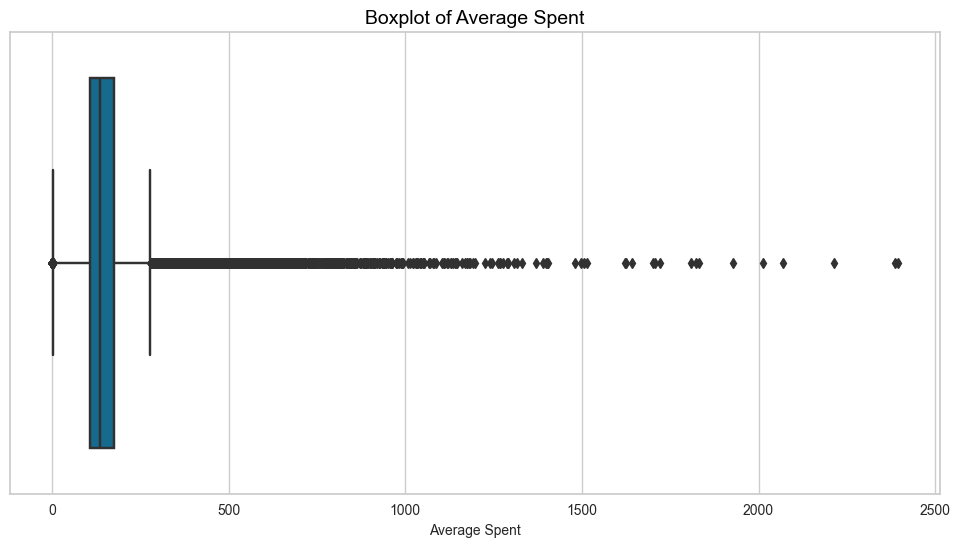

In [128]:
#Do a boxplot of the average spent
plt.figure(figsize=(12, 6))
sns.boxplot(data=ds, x='AverageSpentNight')
plt.title('Boxplot of Average Spent', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Average Spent', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.show()

In [129]:
#Turn the spent night into cheap, average, expensive, elite with the following bins [-1, 100, 200, 400, 9999]
ds['SpentNightGroup'] = pd.cut(ds['AverageSpentNight'], bins=[-1, 100, 200, 400, 9999], labels=['Cheap', 'Average', 'Expensive', 'Elite'])
ds['SpentNightGroup'].value_counts()

SpentNightGroup
Average      44775
Cheap        15112
Expensive     9995
Elite         2735
Name: count, dtype: int64

In [130]:
ds.drop(['AverageSpentNight'], axis=1, inplace=True)

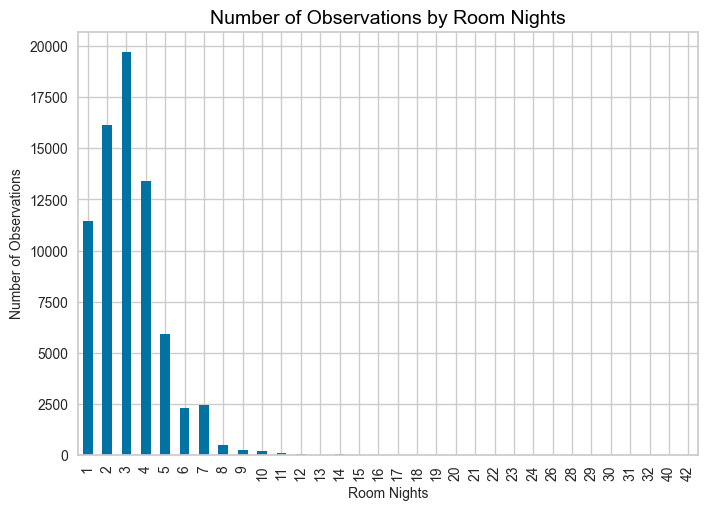

In [131]:
#Do a bar plot with the room nights
ds['RoomNights'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations by Room Nights', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Room Nights', fontsize=subPlots_label_fontSize)
plt.ylabel('Number of Observations', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.show()

In [132]:
#Turn the room nights that are between 0 and 4 to 1-4days, 5-7 to 5--7days, and the rest to 8+days
ds['RoomNights'] = ds['RoomNights'].apply(lambda x: 
                                          '1-2 days' if x <= 2 else 
                                          ('3-4 days' if x <= 4 else  
                                            '5 + days'))


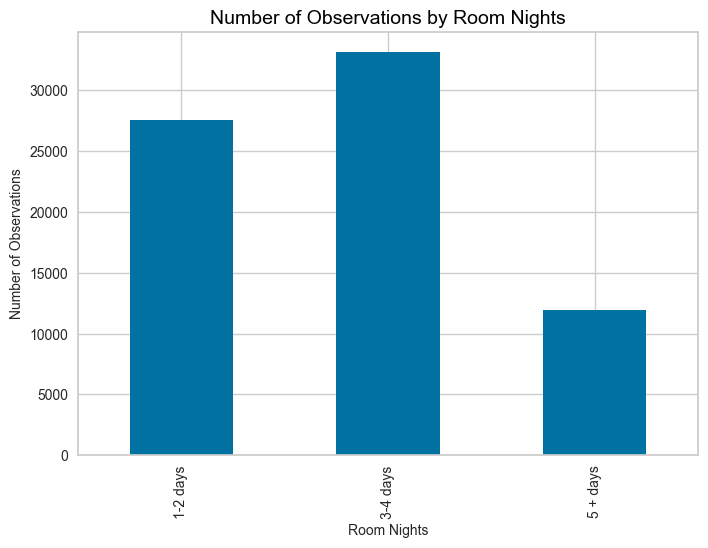

In [133]:
#Do a bar plot with the room nights
ds['RoomNights'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations by Room Nights', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Room Nights', fontsize=subPlots_label_fontSize)
plt.ylabel('Number of Observations', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.show()

# feature Engineering

In [134]:
#Are there any cases of Bookingcanceled > 0 and BookingsCheckedIn + BookingsNoShowed = 0
ds[(ds['BookingsCanceled'] > 0) & ((ds['BookingsCheckedIn'] + ds['BookingsNoShowed']) == 0)].shape[0]

0

In [135]:
#drop that row
ds = ds.drop(ds[(ds['BookingsCanceled'] > 0) & ((ds['BookingsCheckedIn'] + ds['BookingsNoShowed']) == 0)].index)

In [136]:
#New variable called rate_cancel which is the number of (BookingsCanceled / (BookingsCheckedin + BookingsNoShowed))
ds['HaveCanceled'] = ds['BookingsCanceled'] / (ds['BookingsCheckedIn'] + ds['BookingsNoShowed'])
#Check for nans
ds['HaveCanceled'].isna().sum() #Here the nans represent the people that never booked anything
#Fill the nans with 0
ds['HaveCanceled'] = ds['HaveCanceled'].fillna(0)

In [137]:
#Whats the max and min of the HaveCanceled
ds['HaveCanceled'].min(), ds['HaveCanceled'].max()

(0.0, 2.0)

In [138]:
#Check the number of unique values
ds['HaveCanceled'].value_counts()

HaveCanceled
0.000000    72521
1.000000       27
0.500000       20
0.333333        7
0.250000        6
0.166667        5
0.142857        5
0.125000        3
0.200000        3
0.062500        2
0.090909        2
0.100000        2
0.428571        2
2.000000        2
0.285714        2
0.375000        1
0.076923        1
0.272727        1
0.133333        1
0.230769        1
0.300000        1
0.066667        1
0.111111        1
Name: count, dtype: int64

In [139]:
#Turn the HaveCanceled into a binary variable, 1 if HaveCanceled > 0, 0 otherwise
ds['HaveCanceled'] = ds['HaveCanceled'].apply(lambda x: 1 if x > 0 else 0)
ds['HaveCanceled'].value_counts()

HaveCanceled
0    72521
1       96
Name: count, dtype: int64

## The data states that its prior to 2018, so lets assume it was made in the middle of the year

## Feature Engineering

In [140]:
#What is the min max of the days since creation
ds['DaysSinceCreation'].min(), ds['DaysSinceCreation'].max()

(36.0, 1385.0)

In [141]:
#Create a new column with the Assumed_date that is the 1st of July 2018 minus the DaysSinceCreation
ds['Assumed_date'] = pd.to_datetime('2018-07-01') - pd.to_timedelta(ds['DaysSinceCreation'], unit='D')

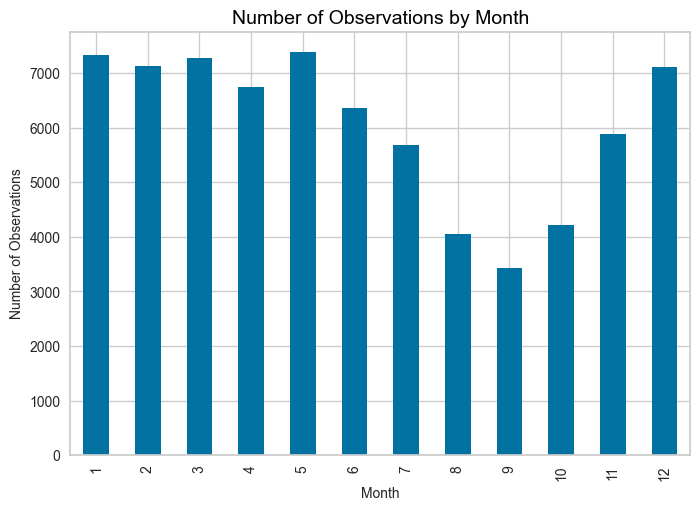

In [142]:
#Do a bar plot of the number of observations by the assumed date, but the x axis should only have the months
ds['Assumed_date'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations by Month', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Month', fontsize=subPlots_label_fontSize)
plt.ylabel('Number of Observations', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.show()


## By looing at this graph we could assume that the winter, which should be the time of the year with the least cases

In [143]:
#Change the assumed month

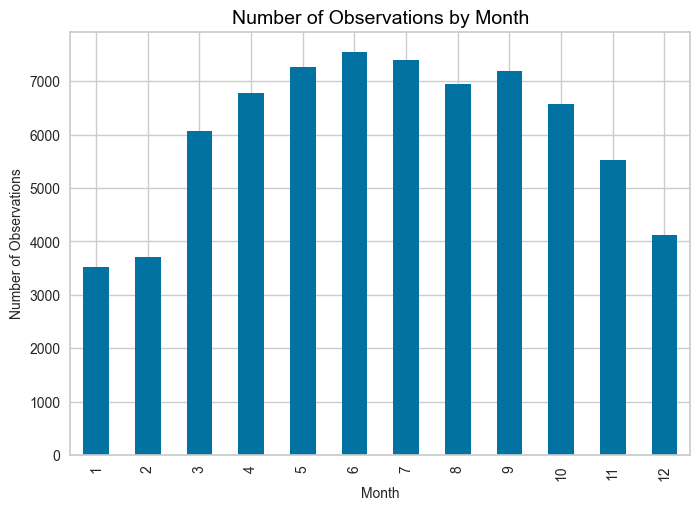

In [144]:
ds['Assumed_date'] = pd.to_datetime('2018-11-01') - pd.to_timedelta(ds['DaysSinceCreation'], unit='D')

ds['Assumed_date'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Observations by Month', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Month', fontsize=subPlots_label_fontSize)
plt.ylabel('Number of Observations', fontsize=subPlots_label_fontSize)
plt.xticks(fontsize=subPlots_xAxis_fontSize)
plt.yticks(fontsize=subPlots_yAxis_fontSize)
plt.show()

In [145]:
#Check if there are any nans in the entire dataset
ds.isna().sum().sum()
#Check which cloumns have nans
ds.isna().sum()[ds.isna().sum() > 0]

Series([], dtype: int64)

In [146]:
#Create a new binary variable called High_Demand that is 1 if the month of the assumed date is >= 3 and <=10 and 0 otherwise
#ds['High_Demand'] = (ds['Assumed_date'].dt.month >= 3) & (ds['Assumed_date'].dt.month <= 10)

In [147]:
#ds['High_Demand'].unique()

In [148]:
#Convert the High_Demand to int
#ds['High_Demand'] = ds['High_Demand'].astype(int)
#ds['High_Demand'].unique()

In [149]:
#drop the assumed date
ds.drop(['Assumed_date'], axis=1, inplace=True)

In [150]:
#Check the min and max of the average lead time
ds['AverageLeadTime'].min(), ds['AverageLeadTime'].max()

(-1, 366)

In [151]:
#Incoherences
#Remove the average lead time that is negative
ds = ds[ds['AverageLeadTime'] >= 0]

In [152]:
ds['AverageLeadTime'].unique()

array([ 78,  13,  87,  67,  65,  80,  61,  98,  97,  57,  96,  93,  58,
        38,  85,  60,  11, 109,   1,   7,  94,  95,   2,  63,   0,  69,
        41,  72,  86,  10,  68,  52,  43,  99, 103,  70,  49,  59,  40,
        29,  75,  50,  18,  28,  91,  42,  81,  71,  46,  54,  55,  84,
        56,  83, 101,  23,  44,  31,  12,  45,  39,   4,  66, 102,  77,
        32,  27,  20,  25,  35,   5, 106,  21,  30,   9,  16,  73,  48,
         3,  36,  79,  17,  34,  64,  62,   8,   6,  47,  53,  15,  33,
       105,  14,  88,  22, 129,  19,  51,  92, 137, 132,  26, 128,  24,
       139,  76,  74, 111, 121, 126, 147,  37, 100, 152, 115, 117,  90,
       116, 158, 118, 114, 162, 133, 164, 108, 167, 161, 107, 150, 124,
       119, 149, 145, 113, 110, 112, 157, 130, 151, 131, 134, 122, 176,
       127, 156, 177, 185, 143, 136, 189, 138,  82, 123, 140, 135, 165,
       191, 120, 159,  89, 170, 195, 163, 154, 199, 125, 141, 197, 194,
       166, 148, 186, 169, 168, 144, 104, 208, 209, 216, 142, 22

## Feature Engineering

In [153]:
#New column with the average lead time but its 1week for the first 7days, 2weeks for the next 7days, between 2 weeks and a month, between 1 month and 3 months, between 3 months and 6 months, between 6 months and a year, and more than a year

ds['AverageLeadTimeGroup'] = pd.cut(ds['AverageLeadTime'], bins=[-1, 7, 30, 90, 180, 10000], labels=['0-7days','1-4weeks', '1-3months', '3-6months', '6+months'])

<Axes: xlabel='AverageLeadTimeGroup'>

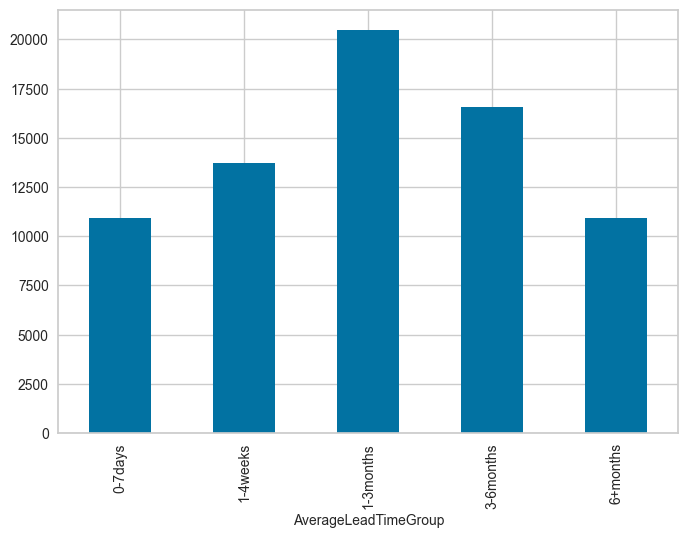

In [154]:
#Check the number of observations by the average lead time group
ds['AverageLeadTimeGroup'].value_counts().sort_index().plot(kind='bar')

In [155]:
#Check the values for days since creation
ds['DaysSinceCreation'].value_counts()

DaysSinceCreation
767.0     182
762.0     181
1208.0    154
387.0     146
522.0     140
         ... 
1377.0      3
1370.0      3
763.0       3
36.0        3
1209.0      1
Name: count, Length: 1349, dtype: int64

In [156]:
ds['DaysSinceCreation'].min(), ds['DaysSinceCreation'].max()

(36.0, 1385.0)

In [157]:
ds.shape[0]

72605

In [158]:
#How many values in the days since creation are under 60
ds[ds['DaysSinceCreation'] < 100].shape[0]  #Aroun 5% are new clients

3527

In [159]:
ds[ds['DaysSinceCreation'] < 350].shape[0] #Around a year

16579

## Feature Engineering

In [160]:
#Create a new feature ClientType, which is New if Days Since Creation < 100, Standard if Days Since Creation < 700, and Old otherwise
ds['ClientType'] = ds['DaysSinceCreation'].apply(lambda x: 'New' if x < 100 else ('Standard' if x < 350 else 'Old'))

In [161]:
ds['ClientType'].value_counts()

ClientType
Old         56026
Standard    13052
New          3527
Name: count, dtype: int64

In [162]:
ds.head()

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,DistributionChannel,MarketSegment,AgeGroup,Geo_Area,TotalUsuallys,TotalRevenue,SpentNightGroup,HaveCanceled,AverageLeadTimeGroup,ClientType
33,34,PRT,44,1385.0,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,78,180.6,100.5,0,...,Direct,Direct,44-59,Portugal,1,281.1,Cheap,0,1-3months,Old
36,37,DEU,31,1385.0,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,13,210.0,73.0,0,...,Travel Agent/Operator,Travel Agent/Operator,28-43,European Union,0,283.0,Cheap,0,1-4weeks,Old
40,41,ITA,53,1385.0,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,87,563.1,90.0,0,...,Travel Agent/Operator,Other,44-59,European Union,0,653.1,Expensive,0,1-3months,Old
42,43,FRA,54,1385.0,0xBD74176CE223A1F5D7B57815926A2288BDEAC2126383...,0x1175CF397EB265DEB63F785870D478E11C4840A2927E...,67,455.7,86.5,0,...,Travel Agent/Operator,Other,44-59,European Union,1,542.2,Average,0,1-3months,Old
44,45,ITA,49,1385.0,0x66B26B3360B77A3357BFA7BBC567DCC1DD1657D028CF...,0x9634AC90EE5A3789EFFDC5FBA3A98FD4005184591905...,87,251.1,40.5,0,...,Travel Agent/Operator,Other,44-59,European Union,0,291.6,Cheap,0,1-3months,Old


In [163]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=ds['DistributionChannel'], columns=ds['MarketSegment'])
table1


MarketSegment,Aviation,Complementary,Corporate,Direct,Groups,Other,Travel Agent/Operator
DistributionChannel,,,,,,,
Corporate,197,8,1418,7,371,27,92
Direct,0,253,35,9205,121,70,21
GDS Systems,0,0,1,5,3,552,5
Travel Agent/Operator,4,85,533,205,7914,40215,11258


In [164]:
table2 = pd.crosstab(index=ds['MarketSegment'], columns=ds['DistributionChannel'])
table2

DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
MarketSegment,,,,
Aviation,197,0,0,4
Complementary,8,253,0,85
Corporate,1418,35,1,533
Direct,7,9205,5,205
Groups,371,121,3,7914
Other,27,70,552,40215
Travel Agent/Operator,92,21,5,11258


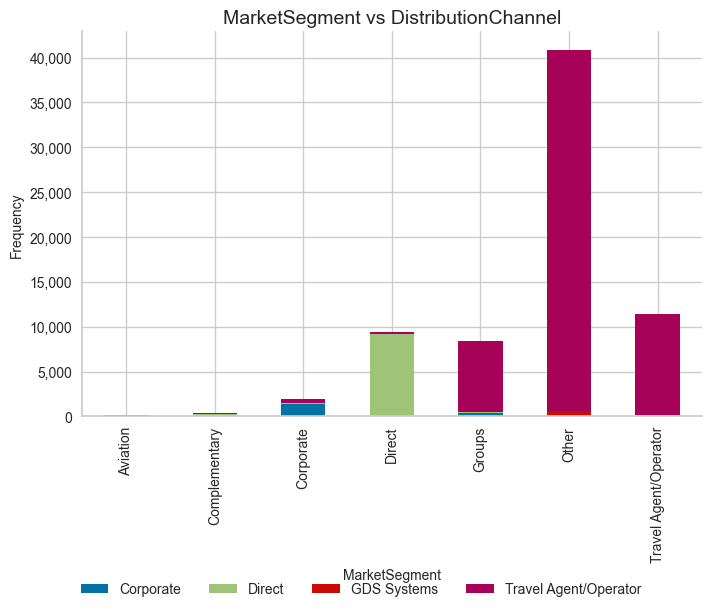

In [165]:
# Visual exploration of the cross table

# Draw
fig, ax = plt.subplots(figsize=(8,5))
table2.plot(kind="bar", 
            ax=ax,
            stacked=True)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("MarketSegment vs DistributionChannel", fontsize=plots_Title_fontSize)
plt.xlabel("MarketSegment")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center', 
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)

In [166]:
# Check missing values
print(ds.isnull().sum())

ID                      0
Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
AgeGroup                0
Geo_Area                0
TotalUsuallys           0
TotalRevenue            0
SpentNightGroup         0
HaveCanceled            0
AverageLeadTimeGroup    0
ClientType              0
dtype: int64


In [167]:
ds['Age'].value_counts()

Age
45    1911
51    1888
50    1878
54    1872
52    1869
      ... 
90       6
93       3
92       1
97       1
91       1
Name: count, Length: 79, dtype: int64

In [168]:
ds['Age'].value_counts().sum()

72605

## Removing  Age, Other Revenue, 'Nationality' Lodging Revenue, Days since creation and Assumed date - SR

In [169]:
#ds.drop(['Age', 'OtherRevenue', 'LodgingRevenue', 'DaysSinceCreation', 'Assumed_date', 'Nationality'], axis=1, inplace=True)

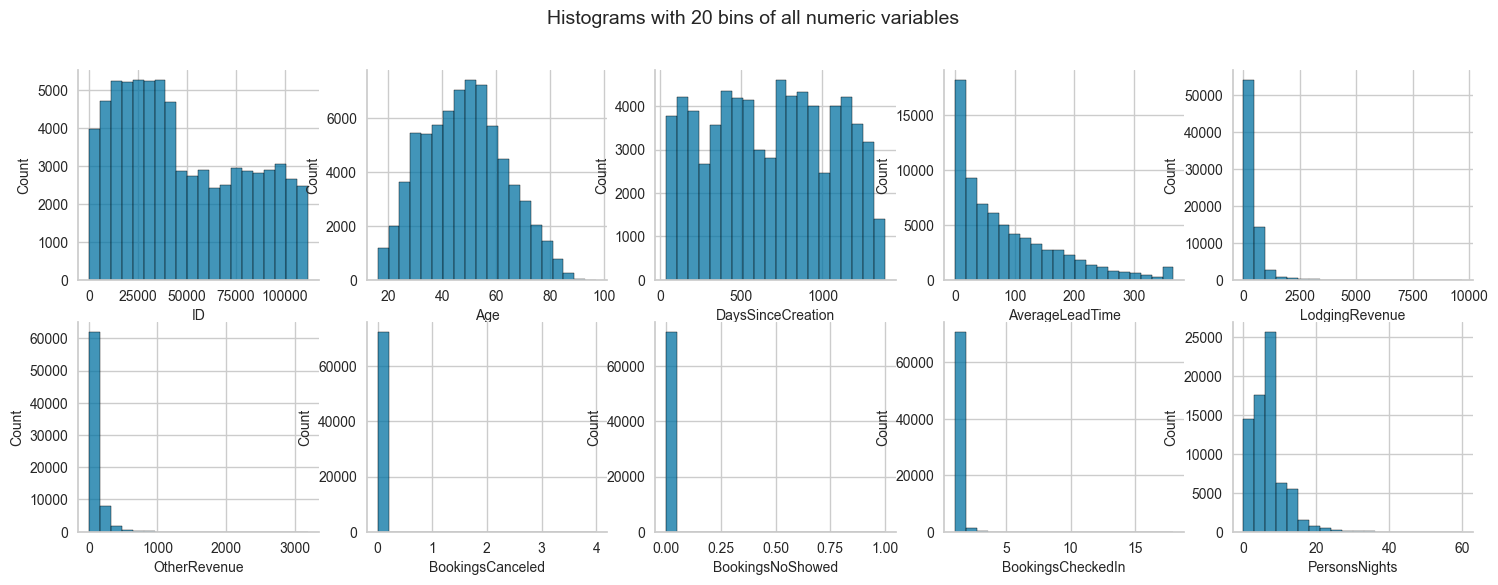

In [170]:
# HISTOGRAM (ALL NUMERIC VARIABLES)                                                

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);

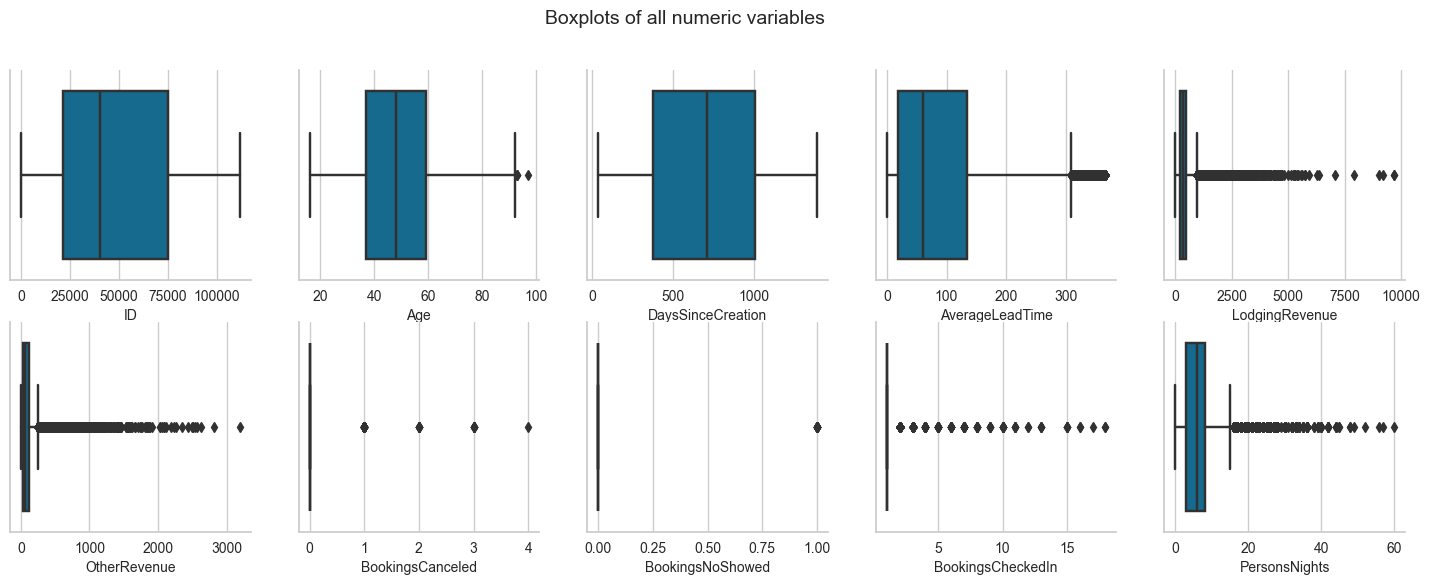

In [171]:
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize);

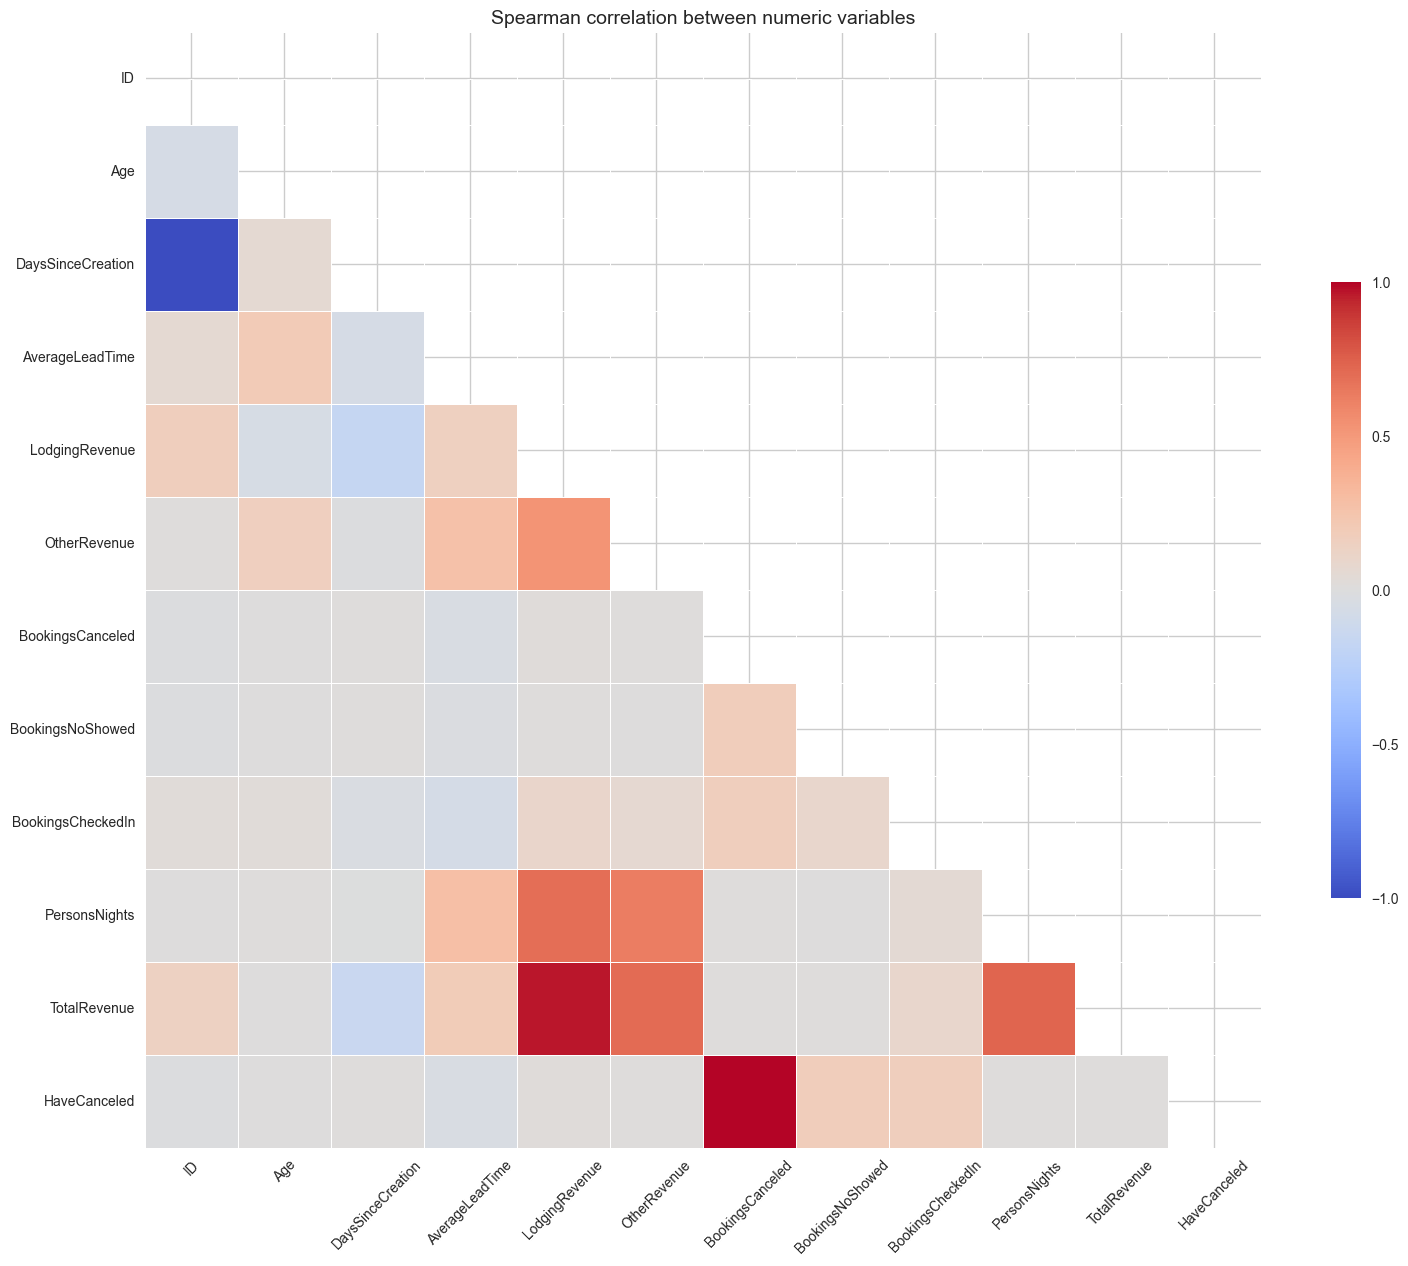

In [172]:
# CORRELATION 

# Create correlation matrix
corr = ds[numerical].corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(18, 20))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [173]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72605 entries, 33 to 111731
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    72605 non-null  int64   
 1   Nationality           72605 non-null  object  
 2   Age                   72605 non-null  int32   
 3   DaysSinceCreation     72605 non-null  float64 
 4   NameHash              72605 non-null  object  
 5   DocIDHash             72605 non-null  object  
 6   AverageLeadTime       72605 non-null  int64   
 7   LodgingRevenue        72605 non-null  float64 
 8   OtherRevenue          72605 non-null  float64 
 9   BookingsCanceled      72605 non-null  int64   
 10  BookingsNoShowed      72605 non-null  int64   
 11  BookingsCheckedIn     72605 non-null  int64   
 12  PersonsNights         72605 non-null  int64   
 13  RoomNights            72605 non-null  object  
 14  DistributionChannel   72605 non-null  object  
 15  Marke

In [174]:
# Check missing values
print(ds.isnull().sum())

ID                      0
Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
AgeGroup                0
Geo_Area                0
TotalUsuallys           0
TotalRevenue            0
SpentNightGroup         0
HaveCanceled            0
AverageLeadTimeGroup    0
ClientType              0
dtype: int64


In [175]:
#Check the last 12 columns
ds.iloc[:, -12:].head()


,PersonsNights,RoomNights,DistributionChannel,MarketSegment,AgeGroup,Geo_Area,TotalUsuallys,TotalRevenue,SpentNightGroup,HaveCanceled,AverageLeadTimeGroup,ClientType
33,6,3-4 days,Direct,Direct,44-59,Portugal,1,281.1,Cheap,0,1-3months,Old
36,8,3-4 days,Travel Agent/Operator,Travel Agent/Operator,28-43,European Union,0,283.0,Cheap,0,1-4weeks,Old
40,6,3-4 days,Travel Agent/Operator,Other,44-59,European Union,0,653.1,Expensive,0,1-3months,Old
42,10,5 + days,Travel Agent/Operator,Other,44-59,European Union,1,542.2,Average,0,1-3months,Old
44,6,3-4 days,Travel Agent/Operator,Other,44-59,European Union,0,291.6,Cheap,0,1-3months,Old


In [176]:
ds.head()

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,DistributionChannel,MarketSegment,AgeGroup,Geo_Area,TotalUsuallys,TotalRevenue,SpentNightGroup,HaveCanceled,AverageLeadTimeGroup,ClientType
33,34,PRT,44,1385.0,0x64CC0D8F6996BA9DD953EF3DC6915783AADF501AFB91...,0x9C421DF9D9356FD9B640578FF30098E73EC22ABC2DA1...,78,180.6,100.5,0,...,Direct,Direct,44-59,Portugal,1,281.1,Cheap,0,1-3months,Old
36,37,DEU,31,1385.0,0x88A4943CEB69F85C84D285CBBF40CE423DB8A2654D96...,0x9F8F3970BC0FEDF1E17DAFEAF7AB49088DE94949EF9D...,13,210.0,73.0,0,...,Travel Agent/Operator,Travel Agent/Operator,28-43,European Union,0,283.0,Cheap,0,1-4weeks,Old
40,41,ITA,53,1385.0,0x31F1F72C984A82336217815498A6F5CF06AC2EBED4B4...,0xB68FC98FB6CBC81ABDEF37870883D5F7ABA17D051AD4...,87,563.1,90.0,0,...,Travel Agent/Operator,Other,44-59,European Union,0,653.1,Expensive,0,1-3months,Old
42,43,FRA,54,1385.0,0xBD74176CE223A1F5D7B57815926A2288BDEAC2126383...,0x1175CF397EB265DEB63F785870D478E11C4840A2927E...,67,455.7,86.5,0,...,Travel Agent/Operator,Other,44-59,European Union,1,542.2,Average,0,1-3months,Old
44,45,ITA,49,1385.0,0x66B26B3360B77A3357BFA7BBC567DCC1DD1657D028CF...,0x9634AC90EE5A3789EFFDC5FBA3A98FD4005184591905...,87,251.1,40.5,0,...,Travel Agent/Operator,Other,44-59,European Union,0,291.6,Cheap,0,1-3months,Old


In [177]:
#Drop ID, NameHash, DocIDHash
ds.drop(['ID', 'NameHash', 'DocIDHash'], axis=1, inplace=True)
ds.head()

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,DistributionChannel,MarketSegment,AgeGroup,Geo_Area,TotalUsuallys,TotalRevenue,SpentNightGroup,HaveCanceled,AverageLeadTimeGroup,ClientType
33,PRT,44,1385.0,78,180.6,100.5,0,0,1,6,...,Direct,Direct,44-59,Portugal,1,281.1,Cheap,0,1-3months,Old
36,DEU,31,1385.0,13,210.0,73.0,0,0,1,8,...,Travel Agent/Operator,Travel Agent/Operator,28-43,European Union,0,283.0,Cheap,0,1-4weeks,Old
40,ITA,53,1385.0,87,563.1,90.0,0,0,1,6,...,Travel Agent/Operator,Other,44-59,European Union,0,653.1,Expensive,0,1-3months,Old
42,FRA,54,1385.0,67,455.7,86.5,0,0,1,10,...,Travel Agent/Operator,Other,44-59,European Union,1,542.2,Average,0,1-3months,Old
44,ITA,49,1385.0,87,251.1,40.5,0,0,1,6,...,Travel Agent/Operator,Other,44-59,European Union,0,291.6,Cheap,0,1-3months,Old


In [178]:
ds.shape

(72605, 21)

In [179]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72605 entries, 33 to 111731
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Nationality           72605 non-null  object  
 1   Age                   72605 non-null  int32   
 2   DaysSinceCreation     72605 non-null  float64 
 3   AverageLeadTime       72605 non-null  int64   
 4   LodgingRevenue        72605 non-null  float64 
 5   OtherRevenue          72605 non-null  float64 
 6   BookingsCanceled      72605 non-null  int64   
 7   BookingsNoShowed      72605 non-null  int64   
 8   BookingsCheckedIn     72605 non-null  int64   
 9   PersonsNights         72605 non-null  int64   
 10  RoomNights            72605 non-null  object  
 11  DistributionChannel   72605 non-null  object  
 12  MarketSegment         72605 non-null  object  
 13  AgeGroup              72605 non-null  category
 14  Geo_Area              72605 non-null  object  
 15  Total

In [180]:
# Drop persons nights and market segment because it is correlated with dist channel which is more important
ds.drop(['PersonsNights', 'MarketSegment'], axis=1, inplace=True)

In [181]:
# Drop
ds.drop(['Nationality', 'Age', 'DaysSinceCreation', 'AverageLeadTime'], axis=1, inplace=True)

In [182]:
# Drop ? 
ds.drop(['LodgingRevenue', 'OtherRevenue', 'BookingsCheckedIn', 'BookingsCanceled', 'BookingsNoShowed'], axis=1, inplace=True)

In [183]:
# Só Mexi Até AQUI

# Só Mexi Até AQUI

# Só Mexi Até AQUI

# Só Mexi Até AQUI

In [184]:
# Features that are not numeric
# 'ClientType', 'Geo_Area', 'RoomNights', 'AverageLeadTimeGroup', 'SpentNightGroup', 'DistributionChannel', 'AgeGroup', 'TotalUsuallys'

In [185]:
# Turn categorical variables into numerical

# Encode categorical variables to dummy variables
cols = ['ClientType', 'Geo_Area', 'RoomNights', 'AverageLeadTimeGroup', 'SpentNightGroup', 'DistributionChannel', 'AgeGroup', 'TotalUsuallys']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
ds = ce_one_hot.fit_transform(ds)

In [186]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72605 entries, 33 to 111731
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   RoomNights_3-4 days                        72605 non-null  int64  
 1   RoomNights_5 + days                        72605 non-null  int64  
 2   RoomNights_1-2 days                        72605 non-null  int64  
 3   DistributionChannel_Direct                 72605 non-null  int64  
 4   DistributionChannel_Travel Agent/Operator  72605 non-null  int64  
 5   DistributionChannel_Corporate              72605 non-null  int64  
 6   DistributionChannel_GDS Systems            72605 non-null  int64  
 7   AgeGroup_16-27                             72605 non-null  int64  
 8   AgeGroup_28-43                             72605 non-null  int64  
 9   AgeGroup_44-59                             72605 non-null  int64  
 10  AgeGroup_>=60            

In [187]:
# Get a copy of the dataframe before normalization for results' analysis
ds_beforeNorm = ds.copy(deep=True)

In [188]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
ds = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(ds.values), columns=ds.columns,index=ds.index)

In [189]:
# Check dataframe structure and statistics after all transformations
print(ds.shape)
ds.describe(include='all').T

(72605, 35)


,count,mean,std,min,25%,50%,75%,max
RoomNights_3-4 days,72605.0,0.456112,0.498074,0.0,0.000000,0.000000,1.000000,1.0
RoomNights_5 + days,72605.0,0.164286,0.370538,0.0,0.000000,0.000000,0.000000,1.0
RoomNights_1-2 days,72605.0,0.379602,0.485291,0.0,0.000000,0.000000,1.000000,1.0
DistributionChannel_Direct,72605.0,0.133668,0.340298,0.0,0.000000,0.000000,0.000000,1.0
DistributionChannel_Travel Agent/Operator,72605.0,0.829337,0.376217,0.0,1.000000,1.000000,1.000000,1.0
DistributionChannel_Corporate,72605.0,0.029199,0.168365,0.0,0.000000,0.000000,0.000000,1.0
DistributionChannel_GDS Systems,72605.0,0.007796,0.087949,0.0,0.000000,0.000000,0.000000,1.0
AgeGroup_16-27,72605.0,0.078232,0.268537,0.0,0.000000,0.000000,0.000000,1.0
AgeGroup_28-43,72605.0,0.308161,0.461736,0.0,0.000000,0.000000,1.000000,1.0
AgeGroup_44-59,72605.0,0.382329,0.485960,0.0,0.000000,0.000000,1.000000,1.0


(72605, 2)


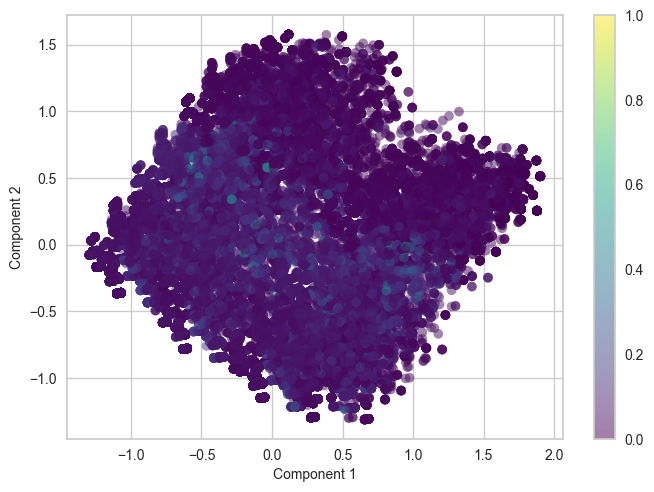

In [190]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(ds)
ds_pca2 = pca2.transform(ds)
print(ds_pca2.shape)

# Scatter plot of the two Principal Components by the "TotalRevenue" to see if there is any pattern
plt.scatter(ds_pca2[:, 0], ds_pca2[:, 1], c=ds.TotalRevenue, edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

In [191]:
# Fit the PCA algorithm to data 
pca = PCA().fit(ds)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(ds.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.114758,0.114758
1,2,0.100137,0.214895
2,3,0.079075,0.293971
3,4,0.077000,0.370971
4,5,0.070315,0.441285
5,6,0.061404,0.502689
6,7,0.058554,0.561243
7,8,0.057462,0.618704
8,9,0.049453,0.668158
9,10,0.048351,0.716509


Text(0.5, 1.0, 'Explained variance by components')

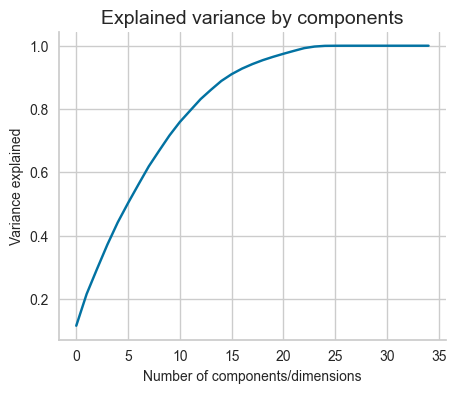

In [192]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.title('Explained variance by components', fontsize=plots_Title_fontSize)

In [193]:
# Apply the dimension reduction to the dataset (for 15 components)
pca_reduced = PCA(n_components = 15)
pca_reduced.fit(ds)
ds_pca_reduced = pca_reduced.transform(ds) 
print(ds_pca_reduced.shape)

(72605, 15)


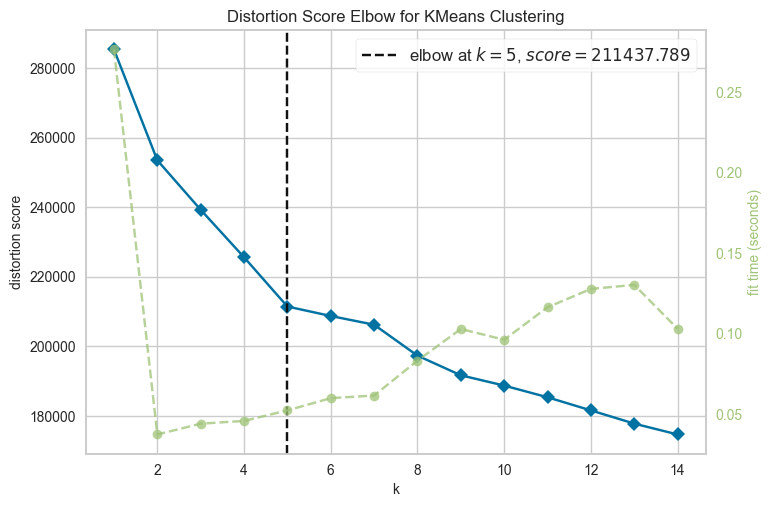

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [194]:
# Apply the Elbow method to select K
km = KMeans(random_state=123)
visualizer = KElbowVisualizer(km, k=(1,15), random_state=123)
visualizer.fit(ds_pca_reduced)
visualizer.show() 

In [195]:
# Apply the K-Means for K=5
K=5
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(ds_pca_reduced)
y_kmeans = kmeans.predict(ds_pca_reduced)

In [196]:
# Visualize Silhouette 
#visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
#visualizer.fit(ds_pca_reduced)
#visualizer.show()

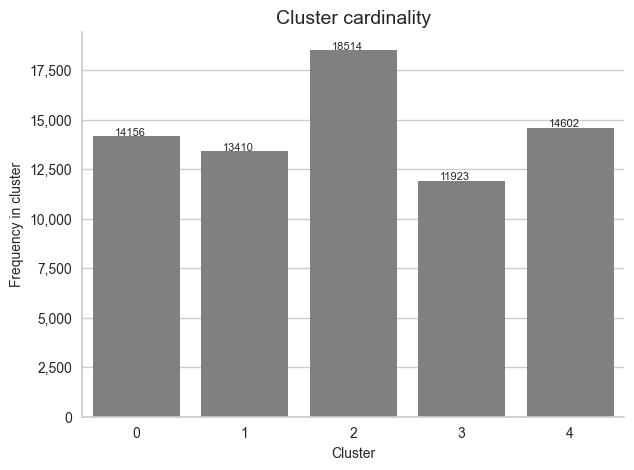

In [197]:
# Plot clusters cardinality 

# Count observations per cluster
freqByCluster = ds_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)

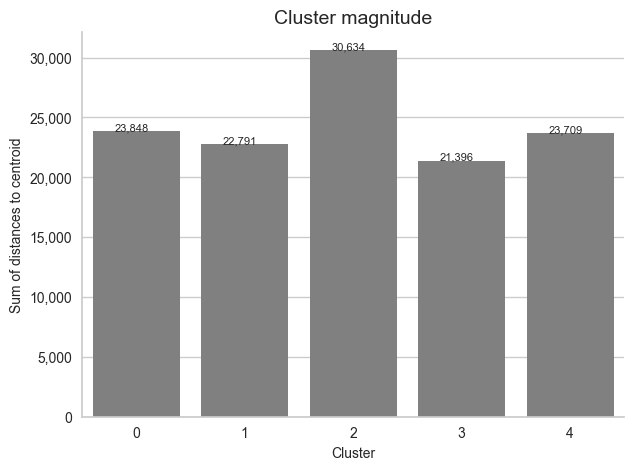

In [198]:
# Plot clusters magnitude

# Compute Magnitude
ds['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = ds['distanceToCentroid'].groupby(y_kmeans).sum()
ds = ds.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)

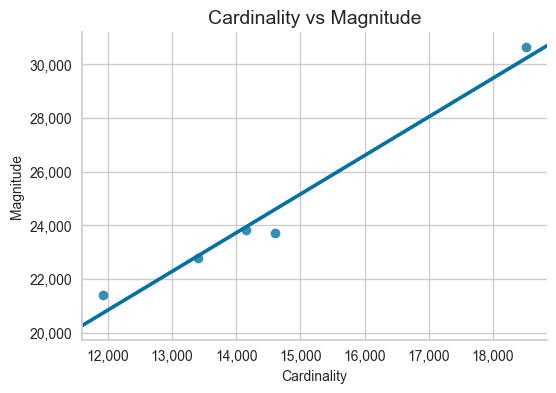

In [199]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)

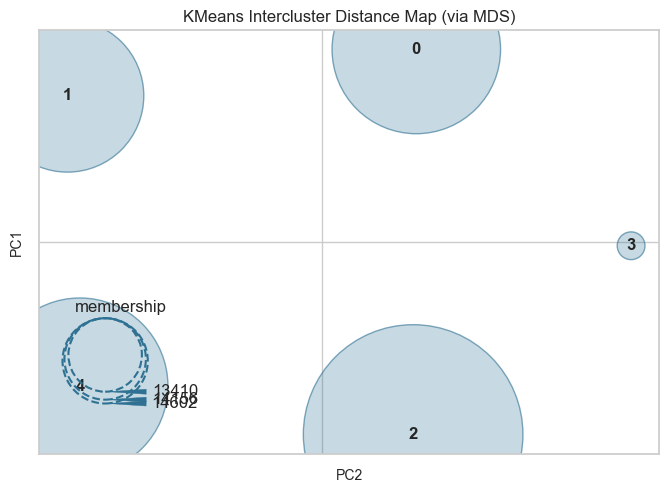

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [200]:
# Visualizing the clusters sizes and distances in 2D
visualizer = InterclusterDistance(kmeans)
visualizer.fit(ds_pca_reduced)
visualizer.show()

In [201]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=ds.columns)
wheightsDF

,RoomNights_3-4 days,RoomNights_5 + days,RoomNights_1-2 days,DistributionChannel_Direct,DistributionChannel_Travel Agent/Operator,DistributionChannel_Corporate,DistributionChannel_GDS Systems,AgeGroup_16-27,AgeGroup_28-43,AgeGroup_44-59,...,SpentNightGroup_Elite,HaveCanceled,AverageLeadTimeGroup_0-7days,AverageLeadTimeGroup_1-4weeks,AverageLeadTimeGroup_1-3months,AverageLeadTimeGroup_3-6months,AverageLeadTimeGroup_6+months,ClientType_Old,ClientType_Standard,ClientType_New
0,-0.332596,-7.056794e-03,3.396530e-01,0.160400,-0.219847,0.047541,0.011906,-0.011532,0.067157,0.044142,...,0.009270,1.248100e-03,0.169615,0.055117,-0.061115,-0.088893,-0.074724,0.026403,-0.000965,-0.025438
1,-0.526916,1.271559e-02,5.142003e-01,-0.008930,0.005098,0.002265,0.001567,0.007023,0.104290,-0.154521,...,0.003063,5.464390e-04,0.121266,0.054023,-0.091405,-0.095910,0.012026,-0.069382,0.048106,0.021277
2,0.165476,-3.098776e-02,-1.344887e-01,-0.020981,0.026200,-0.004069,-0.001150,0.031110,0.501018,-0.548115,...,0.019303,-4.341356e-04,-0.030336,0.043564,0.148756,-0.090717,-0.071268,-0.161260,0.164342,-0.003082
3,-0.007805,2.903017e-02,-2.122531e-02,-0.030477,0.034548,-0.000687,-0.003384,0.002174,-0.312782,0.498373,...,0.035756,1.444641e-03,0.011200,0.024922,0.064444,-0.041757,-0.058808,-0.000068,0.009627,-0.009559
4,0.068584,9.707583e-03,-7.829164e-02,0.177219,-0.199599,0.013596,0.008783,0.017311,-0.022606,0.192401,...,-0.008383,3.379269e-04,0.037062,0.077652,0.066324,-0.113815,-0.067223,-0.649274,0.576370,0.072903
5,-0.134136,9.458495e-02,3.955136e-02,-0.132119,0.158597,-0.020457,-0.006020,0.042178,-0.460316,-0.197504,...,-0.002730,-9.879956e-04,-0.101612,-0.069114,-0.118218,0.034811,0.254133,-0.263015,0.216825,0.046190
6,0.279676,-1.082051e-01,-1.714706e-01,0.190121,-0.222263,0.034606,-0.002463,-0.003338,-0.078593,-0.060857,...,0.003918,2.233737e-03,0.141047,0.095925,-0.537506,0.284349,0.016186,0.028589,-0.036692,0.008103
7,0.156322,-1.444433e-01,-1.187862e-02,0.069493,-0.086035,0.018747,-0.002205,-0.009592,-0.205887,-0.019836,...,-0.013069,8.347945e-04,0.022911,-0.178253,0.586940,-0.412893,-0.018704,0.108813,-0.069418,-0.039395
8,-0.308200,5.880500e-01,-2.798503e-01,0.236663,-0.235064,0.002132,-0.003731,0.045726,0.004561,-0.072891,...,0.011295,2.174934e-03,-0.044498,-0.383024,0.214058,0.354690,-0.141227,0.013994,-0.050006,0.036013
9,0.088092,-1.543871e-01,6.629499e-02,0.466271,-0.501948,0.024312,0.011364,-0.004397,-0.077012,-0.106159,...,0.027748,8.795538e-04,0.093013,-0.016324,-0.023642,-0.203665,0.150617,0.099692,-0.102988,0.003296


In [202]:
# Study the weights of component 19 
comp = abs(wheightsDF.iloc[24])  
comp = comp.sort_values(ascending=False)
comp

DistributionChannel_GDS Systems              0.862097
DistributionChannel_Corporate                0.360553
DistributionChannel_Direct                   0.257637
DistributionChannel_Travel Agent/Operator    0.243907
Geo_Area_Portugal                            0.018578
Geo_Area_North America                       0.010691
HaveCanceled                                 0.008460
Geo_Area_European Union                      0.007412
RoomNights_1-2 days                          0.006893
AverageLeadTimeGroup_1-4weeks                0.006378
AverageLeadTimeGroup_6+months                0.006111
AverageLeadTimeGroup_0-7days                 0.005061
AverageLeadTimeGroup_3-6months               0.005044
TotalUsuallys_0                              0.004621
Geo_Area_Europe                              0.004166
RoomNights_5 + days                          0.003933
AgeGroup_>=60                                0.003634
ClientType_Standard                          0.003495
SpentNightGroup_Elite       

In [203]:
# Check the mean values of each cluster 
top_features = comp[:100].index
clustersMeanDF = pd.DataFrame(ds_beforeNorm[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose()

,0,1,2,3,4
DistributionChannel_GDS Systems,0.004945,0.024609,0.001134,0.003690,0.006917
DistributionChannel_Corporate,0.013210,0.073080,0.005779,0.026839,0.036022
DistributionChannel_Direct,0.079118,0.236167,0.077401,0.141491,0.157376
DistributionChannel_Travel Agent/Operator,0.902727,0.666145,0.915685,0.827980,0.799685
Geo_Area_Portugal,0.131534,0.219463,0.045155,0.057116,0.074510
Geo_Area_North America,0.091269,0.061596,0.070055,0.059884,0.046158
HaveCanceled,0.000777,0.000895,0.000378,0.004613,0.000753
Geo_Area_European Union,0.616700,0.586130,0.738900,0.710224,0.764827
RoomNights_1-2 days,1.000000,0.999627,0.000000,0.000000,0.000000
AverageLeadTimeGroup_1-4weeks,0.219907,0.221626,0.171924,0.155749,0.176277


In [204]:
# Cluster 0 example
# - 73% EU
# - 92% clientype_old
# - 83% RoomNights_1-4days
# - 100% SpentNightGroup_Average
# - 80% TotalUsuallys_1
# - (totalrevenue medium)

# Cluster 1 example
# - 67% EU
# - 44% SpentNightGroup_Expensive
# - 43% SpentNightGroup_Cheap
# - 93% clientype_old
# - 86% TotalUsuallys_1
# - 83% RoomNights_1-4days
# - (totalrevenue high)

# Cluster 2 example
# - 70% EU
# - 78% SpentNightGroup_Average
# - 94% clientype_old
# - 99,8% TotalUsuallys_0
# - 84% RoomNights_1-4days
# - (totalrevenue high)

# Cluster 3 example
# - 66% EU
# - 68% SpentNightGroup_Average
# - 99,9% clientype_standard
# - 53% TotalUsuallys_1
# - 83% RoomNights_1-4days
# - (totalrevenue high)

# Cluster 4 example
# - 65% EU + 19% Portugal
# - 99,5% SpentNightGroup_Cheap
# - 82% clientype_Old + 16% clientype_standard
# - 94% TotalUsuallys_0
# - 84% RoomNights_1-4days
# - (totalrevenue Low)


In [205]:
# (kmeans distance metrics)

In [206]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(ds, y_kmeans)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.10721511657082805
